# Devoir 2 – Question 1(a) : Squelette de Code (Version TA)

Ce notebook fournit **uniquement la structure** nécessaire pour réaliser la partie **1(a)** du devoir :

**→ Sélection aléatoire de 50 firmes du S&P 500 + extraction des prix, EPS et trailing P/E.**

⚠️ **Ce fichier NE contient aucune solution.**  
Toutes les étapes critiques (fusion, calcul du trailing P/E, gestion des dates) sont volontairement remplacées par des `TODO`.

Votre rôle est de compléter les parties manquantes.


### Problème 1a

In [2]:
# ============================================
# 0. Connexion WRDS
# ============================================

import wrds
import pandas as pd
import numpy as np

db = wrds.Connection()


WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\berge\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


#### 1. Charger l'univers S&P 500

Objectif : récupérer les PERMNO des entreprises ayant fait partie du S&P 500 dans la période pertinente.


In [3]:
# ============================================
# 1. Récupération S&P 500
# ============================================

sp500 = db.raw_sql(
    """
    SELECT permno, start, ending
    FROM crsp.msp500list
    WHERE ending >= '2003-01-01'
    """,
    date_cols=['start','ending']
)

sp500.head()


,permno,start,ending
0,10078,1992-08-20,2010-01-28
1,10104,1989-08-03,2024-12-31
2,10107,1994-06-07,2024-12-31
3,10108,2002-07-22,2005-08-11
4,10137,2000-12-11,2011-02-25


#### 2. Ajouter les identifiants CRSP (ticker, nom, codes)

Nous utilisons `crsp.msenames` pour enrichir les informations des firmes.


In [4]:
# ============================================
# 2. Ajouter identifiants firmes
# ============================================

msenames = db.raw_sql(
    """
    SELECT permno, comnam, ticker, ncusip,
           namedt, nameendt, shrcd, exchcd, hsiccd
    FROM crsp.msenames
    """,
    date_cols=['namedt','nameendt']
)

msenames["nameendt"] = msenames["nameendt"].fillna(pd.to_datetime("today"))

sp500_full = pd.merge(sp500, msenames, on="permno", how="left")

# Filtre temporel du nom (structure simple, à adapter si nécessaire)
sp500_full = sp500_full[
    (sp500_full["start"] >= sp500_full["namedt"]) &
    (sp500_full["start"] <= sp500_full["nameendt"])
]

sp500_full.head()


,permno,start,ending,comnam,ticker,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd
0,10078,1992-08-20,2010-01-28,SUN MICROSYSTEMS INC,SUNW,86681010,1986-03-04,2004-06-09,11,3,3571
5,10104,1989-08-03,2024-12-31,ORACLE SYSTEMS CORP,ORCL,68389X10,1986-03-12,1995-05-31,11,3,7379
10,10107,1994-06-07,2024-12-31,MICROSOFT CORP,MSFT,59491810,1986-03-13,2004-06-09,11,3,7370
15,10108,2002-07-22,2005-08-11,SUNGARD DATA SYSTEMS INC,SDS,86736310,2002-01-02,2004-06-09,11,1,7374
22,10137,2000-12-11,2011-02-25,ALLEGHENY ENERGY INC,AYE,01736110,1997-10-01,2002-01-01,11,1,4911


#### 3. Définir l'univers de firmes et tirer 50 firmes au hasard

On obtient une liste unique de PERMNO, puis on tire 50 firmes aléatoirement.


In [5]:
# ============================================
# 3. Tirage aléatoire de 50 firmes
# ============================================

universe = sp500_full.drop_duplicates(subset="permno")

sample_50 = universe.sample(50, random_state=42)

sample_50[["permno","ticker","comnam","hsiccd"]]


,permno,ticker,comnam,hsiccd
1517,22779,<NA>,MOTOROLA INC,3663
3394,58318,TEX,TEREX CORP NEW,3537
6012,88661,COH,COACH INC,3199
4220,75186,SCH,SCHWAB CHARLES CORP NEW,6211
490,12872,MPC,MARATHON PETROLEUM CORP,2911
2073,27422,CLF,CLIFFS NATURAL RESOURCES INC,1081
6483,91380,RBK,REEBOK INTERNATIONAL LTD,3021
5711,86136,SRE,SEMPRA ENERGY,4932
573,13598,KRFT,KRAFT FOODS GROUP INC,9999
4940,79698,IT,GARTNER INC,8732


#### 4. Extraire les prix (daily ou monthly, selon votre choix)

Cette étape récupère les prix CRSP pour les 50 firmes.


In [6]:
# ============================================
# 4. Extraction des prix CRSP
# ============================================

permnos = sample_50["permno"].astype(int).tolist()
permno_str = ",".join(map(str, permnos))

prices = db.raw_sql(
    f"""
    SELECT date, permno, prc, ret, vol, shrout
    FROM crsp.dsf
    WHERE permno IN ({permno_str})
      AND date BETWEEN '2003-01-01' AND '2023-12-31'
    ORDER BY permno, date
    """,
    date_cols=["date"]
)

# Joindre tickers (optionnel)
prices = pd.merge(prices, sample_50[["permno","ticker","comnam"]], on="permno", how="left")

prices.head()
## TODO : # - Corriger PRC négatif # - Gérer NA et valeurs extrêmes
# ============================================
# 4.1 Nettoyage des prix
# ============================================

# 1) Corriger PRC négatif (convention CRSP : signe = côté bid/ask)
prices["prc"] = prices["prc"].abs()

# 2) Retirer les observations sans prix ou sans nombre d’actions
prices = prices.dropna(subset=["prc", "shrout"])

# 3) Filtrer quelques valeurs aberrantes simples sur le prix
#    (seuils arbitraires mais raisonnables pour des actions US)
prices = prices[(prices["prc"] > 0) & (prices["prc"] < 10000)]

prices.head()


,date,permno,prc,ret,vol,shrout,ticker,comnam
0,2003-01-02,11403,11.66,-0.011026,2339600.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
1,2003-01-03,11403,9.24,-0.207547,16931100.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
2,2003-01-06,11403,9.8,0.060606,4575800.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
3,2003-01-07,11403,9.36,-0.044898,2970300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
4,2003-01-08,11403,9.65,0.030983,1754300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC


#### 5. Récupérer EPS (Compustat)

Vous devez maintenant extraire l'EPS depuis Compustat.
Aucune fusion ni calcul n'est fourni.



In [7]:
# ============================================
# 5. Extraction EPS – À compléter
# ============================================

eps_raw = db.get_table(
    "comp", "funda",
    columns=["gvkey","datadate","epspi","tic"]
)

# TODO :
# - Filtrer période
# - Filtrer sur les firmes de l'échantillon
# - Construire un EPS cohérent avec trailing P/E (ex : TTM)
eps_raw["datadate"] = pd.to_datetime(eps_raw["datadate"])

# -------------------------------
# 1) Filtrer sur la période
#    (cohérente avec les prix : 2003-2023)
# -------------------------------
eps = eps_raw[
    (eps_raw["datadate"] >= "2003-01-01") &
    (eps_raw["datadate"] <= "2023-12-31")
].copy()

# -------------------------------
# 2) Filtrer sur les firmes de l'échantillon
#    -> via le ticker (tic dans Compustat)
# -------------------------------
tickers_sample = sample_50["ticker"].dropna().unique()
eps = eps[eps["tic"].isin(tickers_sample)].copy()

# -------------------------------
# 3) Nettoyage de base
# -------------------------------
eps = eps.rename(columns={"epspi": "eps"})
eps = eps[["gvkey", "tic", "datadate", "eps"]]
eps = eps.dropna(subset=["eps"])
eps = eps.sort_values(["tic", "datadate"])

# -------------------------------
# 4) Construire un EPS cohérent avec un trailing P/E
#    Ici : epspi est un EPS ANNUEL (Compustat funda),
#    on l'interprète comme un EPS "trailing 12 mois" (TTM).
#    On crée donc une colonne eps_ttm qui sera utilisée
#    plus tard pour P/E = Price / eps_ttm.
# -------------------------------
eps["eps_ttm"] = eps["eps"]

eps.head()

,gvkey,tic,datadate,eps,eps_ttm
95846,032930,ADT,2016-12-31,-0.72,-0.72
95847,032930,ADT,2017-12-31,0.46,0.46
95848,032930,ADT,2018-12-31,-0.81,-0.81
95850,032930,ADT,2019-12-31,-0.57,-0.57
95852,032930,ADT,2020-12-31,-0.81,-0.81


#### 6. Trailing P/E : squelette

Vous devez fusionner les prix et l'EPS, puis calculer :  

`P/E = Price / EPS`

⚠️ Aucune formule ni fusion finale n'est fournie ici.


In [ ]:
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# Exemple de squelette (à compléter) :

# merged = pd.merge(
#     prices,
#     eps_raw[['tic','datadate','epspi']],   # TODO: remplacer epspi par EPS_TTM si vous le calculez
#     left_on='ticker',
#     right_on='tic',
#     how='left'
# )

# # Conserver EPS antérieur à la date
# merged = merged[merged["datadate"] <= merged["date"]]

# # TODO : Construire trailing P/E
# # merged["pe_trailing"] = merged["prc_abs"] / merged["eps_ttm"]

# merged.head()
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# 1) Fusion simple par ticker (left_on='ticker', right_on='tic')
merged = pd.merge(
    prices,
    eps[['tic', 'datadate', 'eps_ttm']],   # on utilise EPS_TTM construit dans l'étape 5
    left_on='ticker',
    right_on='tic',
    how='left'
)

# 2) Conserver seulement les observations où l'EPS est antérieur ou égal à la date du prix
merged = merged[merged["datadate"] <= merged["date"]]

# 3) Garder seulement la dernière observation EPS AVANT la date du prix
#    (sinon une firme avec plusieurs EPS par année génère plusieurs lignes par date)
merged = merged.sort_values(["permno", "date", "datadate"])
merged = merged.groupby(["permno", "date"]).tail(1)

# 4) Trailing P/E (en excluant EPS = 0)
merged.loc[merged["eps_ttm"] == 0, "eps_ttm"] = np.nan
merged["pe_trailing"] = merged["prc"] / merged["eps_ttm"]


merged.head()
merged[merged["eps_ttm"] > 0].head()



,date,permno,prc,ret,vol,shrout,ticker,comnam,tic,datadate,eps_ttm,pe_trailing
15091,2004-12-31,11403,13.81,-0.006475,752900.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,51.148148
15121,2005-01-03,11403,13.75,-0.004345,980400.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,50.925926
15151,2005-01-04,11403,13.3,-0.032727,1889500.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.259259
15181,2005-01-05,11403,13.31,0.000752,1926100.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.296296
15211,2005-01-06,11403,13.34,0.002254,1389600.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.407407


### Problème 1b

In [9]:
# ============================================
# 1B. Panneau de base pour les transformations
# ============================================

panel = merged.sort_values(["permno", "date"]).copy()
# --------------------------------------------
# 2) Rendements de l'action
#    - ret_simple : rendement simple CRSP
#    - ret_log    : log-rendement pour analyses éventuelles
# --------------------------------------------

panel["ret_simple"] = panel["ret"]                   # déjà en % décimal dans CRSP
panel["ret_log"]    = np.log1p(panel["ret"])         # log(1+ret)
panel[["permno", "date", "ret", "ret_simple", "ret_log"]].head()


,permno,date,ret,ret_simple,ret_log
7530,11403,2003-12-31,-0.009366,-0.009366,-0.00941
7560,11403,2004-01-02,0.015573,0.015573,0.015453
7590,11403,2004-01-05,0.016977,0.016977,0.016835
7620,11403,2004-01-06,0.001616,0.001616,0.001615
7650,11403,2004-01-07,0.017204,0.017204,0.017058


In [10]:
# ============================================
# 1B. Expected EPS : Moyenne glissante simple (par firme)
# Modèle : E[EPS_t] = moyenne des EPS_{t-k} ... EPS_{t-1}
# ============================================

window = 504    # moyenne des 504 derniers EPS

# S'assurer de l'ordre
panel = panel.sort_values(["permno", "date"]).copy()

def compute_expected_eps_ma(series, window=504):
    """
    Calcule expected EPS via une moyenne glissante.
    On utilise exclusivement les EPS réalisés passés (EPS_{t-1}, EPS_{t-2}, ...).

    expected_eps_t = mean(EPS_{t-window}, ..., EPS_{t-1})

    La première valeur de la moyenne est NaN tant qu'il n'y a pas assez d'historique.
    """
    eps_lag = series.shift(1)              # EPS_{t-1}
    expected = eps_lag.rolling(window=window, min_periods=1).mean()
    return expected

# Application firme par firme
panel["eps_expected"] = (
    panel
    .groupby("permno")["eps_ttm"]
    .transform(lambda s: compute_expected_eps_ma(s, window=window))
)

# Vérifications
print("Nombre d'observations avec EPS_expected non manquant :",
      panel["eps_expected"].notna().sum())

print("Corrélation EPS_expected vs EPS_TTM (sur les lignes non manquantes) :",
      panel[["eps_expected", "eps_ttm"]].dropna().corr().iloc[0, 1])

# Exemple sur une firme représentative
sample_permno = panel["permno"].iloc[0]
print(f"\nExemple pour permno = {sample_permno} :")
print(
    panel[panel["permno"] == sample_permno][
        ["date", "eps_ttm", "eps_expected"]
    ].head(15)
)


Nombre d'observations avec EPS_expected non manquant : 133533
Corrélation EPS_expected vs EPS_TTM (sur les lignes non manquantes) : 0.3678163973240031

Exemple pour permno = 11403 :
           date  eps_ttm  eps_expected
7530 2003-12-31    -0.07           NaN
7560 2004-01-02    -0.07         -0.07
7590 2004-01-05    -0.07         -0.07
7620 2004-01-06    -0.07         -0.07
7650 2004-01-07    -0.07         -0.07
7680 2004-01-08    -0.07         -0.07
7710 2004-01-09    -0.07         -0.07
7740 2004-01-12    -0.07         -0.07
7770 2004-01-13    -0.07         -0.07
7800 2004-01-14    -0.07         -0.07
7830 2004-01-15    -0.07         -0.07
7860 2004-01-16    -0.07         -0.07
7890 2004-01-20    -0.07         -0.07
7920 2004-01-21    -0.07         -0.07
7950 2004-01-22    -0.07         -0.07


In [11]:
# --------------------------------------------
# 4) Trailing P/E
#    Définition : P/E_t = Price_t / EPS_TTM_t
# --------------------------------------------

panel["pe_trailing"] = panel["prc"] / panel["eps_ttm"]
#Limiter les valeurs extrêmes
panel.loc[panel["pe_trailing"].abs() > 200, "pe_trailing"] = np.nan



panel[["permno", "date", "prc", "eps_ttm", "pe_trailing"]].head(10)
panel[panel["eps_ttm"] > 0][["permno","date","prc","eps_ttm","pe_trailing"]].head(10)




,permno,date,prc,eps_ttm,pe_trailing
15091,11403,2004-12-31,13.81,0.27,51.148148
15121,11403,2005-01-03,13.75,0.27,50.925926
15151,11403,2005-01-04,13.3,0.27,49.259259
15181,11403,2005-01-05,13.31,0.27,49.296296
15211,11403,2005-01-06,13.34,0.27,49.407407
15241,11403,2005-01-07,13.28,0.27,49.185185
15271,11403,2005-01-10,13.37,0.27,49.518519
15301,11403,2005-01-11,13.57,0.27,50.259259
15331,11403,2005-01-12,13.79,0.27,51.074074
15361,11403,2005-01-13,13.45,0.27,49.814815


### Problème 1c

=== Tableau 1 – Statistiques descriptives globales ===
                      mean     median        std         min          max  \
prc              61.485684  41.850000  71.527937    0.200000   729.919980   
ret_simple        0.000733   0.000545   0.027193   -0.394309     0.685371   
eps_ttm           2.422644   1.880000  12.648032 -182.290000   198.050000   
pe_trailing      19.988584  17.622699  31.147962 -200.000000   199.750000   
composite_ratio  55.784487  37.085348  88.442196 -605.056842  1200.995639   

                        N  
prc              133728.0  
ret_simple       133721.0  
eps_ttm          133314.0  
pe_trailing      128435.0  
composite_ratio  128405.0  

=== Aperçu des stats par titre (premiers tickers) ===
               prc                                             ret_simple  \
              mean  median         std    min        max count       mean   
ticker                                                                      
AJG      63.922936   43.79  

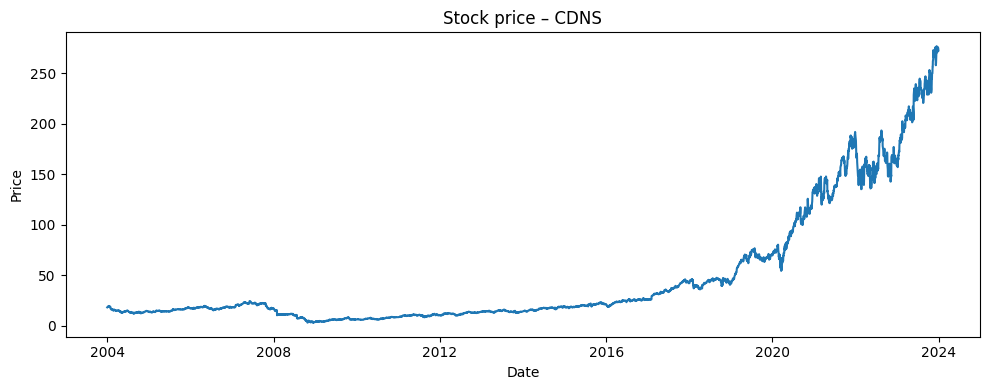

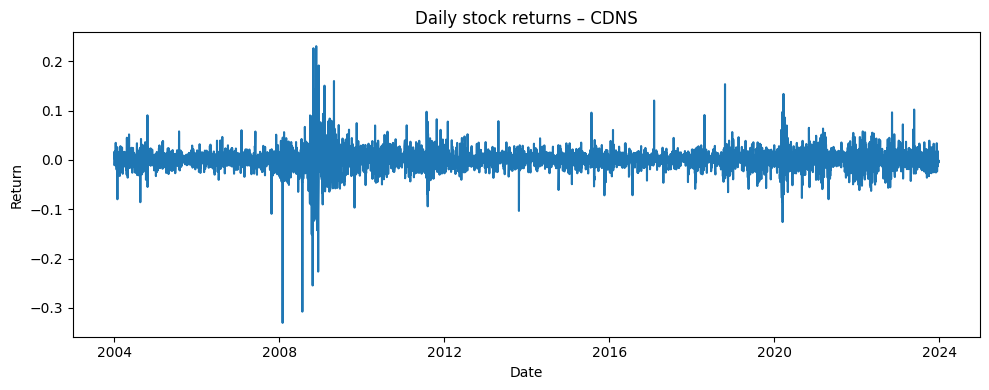

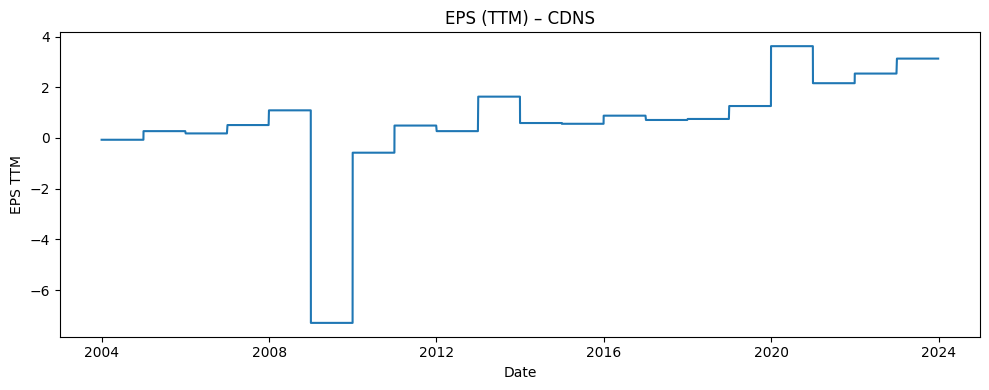

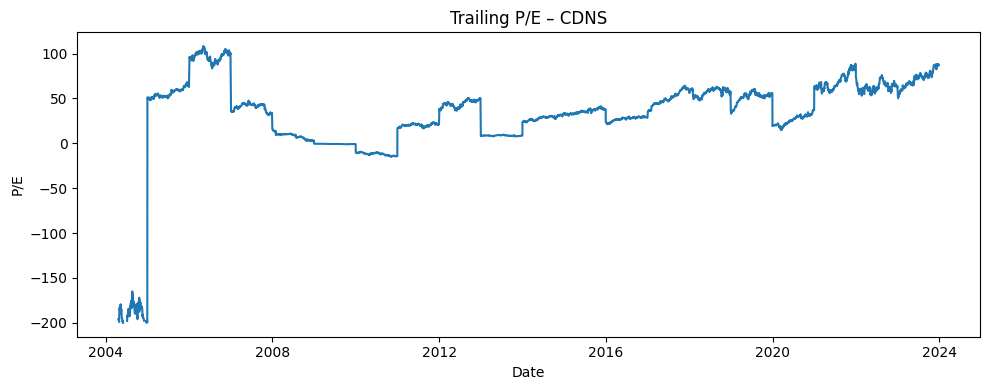

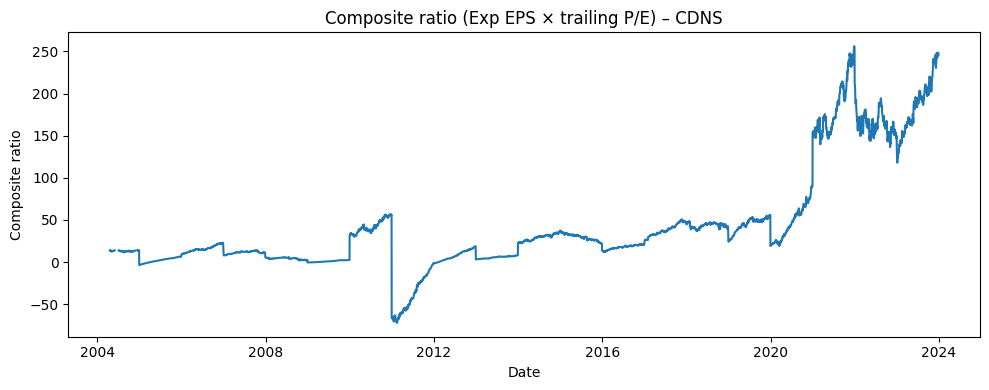

In [12]:

# Problème 1(c) – Tableau descriptif + graphiques


import matplotlib.pyplot as plt

# 1) Composite ratio : Expected EPS × trailing P/E
panel["composite_ratio"] = panel["eps_expected"] * panel["pe_trailing"]

# 2) Tableau de statistiques descriptives globales
vars_1c = ["prc", "ret_simple", "eps_ttm", "pe_trailing", "composite_ratio"]

stats_global = (
    panel[vars_1c]
    .agg(["mean", "median", "std", "min", "max", "count"])
    .T
    .rename(columns={"count": "N"})
)

print("=== Tableau 1 – Statistiques descriptives globales ===")
print(stats_global)

# Un aperçu par titre)
stats_by_ticker = (
    panel
    .groupby("ticker")[vars_1c]
    .agg(["mean", "median", "std", "min", "max", "count"])
)
print("\n=== Aperçu des stats par titre (premiers tickers) ===")
print(stats_by_ticker.head())

# 3) Graphiques de séries temporelles pour une firme représentative,
# J'ai prit le premier ticker dans le panel.
ticker_to_plot = panel["ticker"].dropna().unique()[0]
df_plot = panel[panel["ticker"] == ticker_to_plot].sort_values("date")

print(f"\n=== Graphiques de séries temporelles pour {ticker_to_plot} ===")

series_info = [
    ("Stock price",              "prc",             "Price"),
    ("Daily stock returns",      "ret_simple",      "Return"),
    ("EPS (TTM)",                "eps_ttm",         "EPS TTM"),
    ("Trailing P/E",             "pe_trailing",     "P/E"),
    ("Composite ratio (Exp EPS × trailing P/E)", "composite_ratio", "Composite ratio"),
]

for title_base, col, ylab in series_info:
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot["date"], df_plot[col])
    plt.title(f"{title_base} – {ticker_to_plot}")
    plt.xlabel("Date")
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()


# Problème 2 [20 points], Prévision de prix de base utilisant BPA ×P/B

### Problème 2a – Régression transversale groupée (Pooled Cross-Sectional Regression)

Modèle principal : Prix observé ~ BPA attendu × P/E glissant

In [13]:
# ============================================
# Problème 2(a) – Régression principale
# ============================================

import statsmodels.api as sm
from scipy import stats

# 1) Préparation des données pour la régression
# Variable dépendante : prix observé
# Variable explicative : BPA attendu × P/E glissant (composite_ratio)

# Filtrer les observations valides (sans NaN dans les variables clés)
reg_data = panel[["prc", "composite_ratio"]].dropna().copy()

# S'assurer que les données sont numériques (conversion explicite)
reg_data["prc"] = pd.to_numeric(reg_data["prc"], errors='coerce')
reg_data["composite_ratio"] = pd.to_numeric(reg_data["composite_ratio"], errors='coerce')

# Retirer les valeurs infinies et NaN après conversion
reg_data = reg_data.replace([np.inf, -np.inf], np.nan).dropna()

# Vérifier qu'il reste des données
print(f"Nombre d'observations pour la régression : {len(reg_data)}")

y = reg_data["prc"].to_numpy()
X = reg_data["composite_ratio"].to_numpy().reshape(-1, 1)

# Ajouter une constante pour l'intercept
X_with_const = sm.add_constant(X)

# 2) Estimation du modèle par OLS
model = sm.OLS(y, X_with_const)
results = model.fit()

# 3) Affichage des résultats
print("="*70)
print("MODÈLE PRINCIPAL : Prix ~ BPA attendu × P/E glissant")
print("="*70)
print(results.summary())
print("\n")

# 4) Extraction des statistiques clés
beta_0 = results.params[0]
beta_1 = results.params[1]
r_squared = results.rsquared
r_squared_adj = results.rsquared_adj

print("="*70)
print("RÉSUMÉ DES RÉSULTATS")
print("="*70)
print(f"Coefficient β₀ (Intercept) : {beta_0:.4f}")
print(f"Coefficient β₁ (Composite ratio) : {beta_1:.4f}")
print(f"R² : {r_squared:.4f}")
print(f"R² ajusté : {r_squared_adj:.4f}")
print(f"Nombre d'observations : {int(results.nobs)}")
print("\n")

# Interprétation du coefficient β₁
print("INTERPRÉTATION :")
print(f"Une augmentation de 1 unité du produit (BPA attendu × P/E glissant)")
print(f"est associée à une augmentation de {beta_1:.4f}$ du prix de l'action.")
print(f"Le modèle explique {r_squared*100:.2f}% de la variance des prix.")


Nombre d'observations pour la régression : 128405
MODÈLE PRINCIPAL : Prix ~ BPA attendu × P/E glissant
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 1.493e+05
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:39:37   Log-Likelihood:            -6.8248e+05
No. Observations:              128405   AIC:                         1.365e+06
Df Residuals:                  128403   BIC:                         1.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [ ]:
# ======================================================
# Résidus – Statistiques simples
# ======================================================

residuals = results.resid

print("="*70)
print("STATISTIQUES DES RÉSIDUS")
print("="*70)
print(f"Mean     : {residuals.mean():.6f}")
print(f"Median   : {np.median(residuals):.6f}")
print(f"Std      : {residuals.std():.6f}")
print(f"Min      : {residuals.min():.6f}")
print(f"Max      : {residuals.max():.6f}")


STATISTIQUES DES RÉSIDUS
Mean     : 0.000000
Median   : -8.926425
Std      : 49.212865
Min      : -528.638372
Max      : 490.593674


### Problème 2b - Modèle naïf 1 & 2

In [15]:
# ============================================
# Modèle naïf 1 : Price ~ trailing P/E seul
# ============================================

# 1) Sélection des colonnes
reg_data_pe = panel[["prc", "pe_trailing"]].copy()

# 2) Remplacer les inf par NaN
reg_data_pe = reg_data_pe.replace([np.inf, -np.inf], np.nan)

# 3) Forcer en numérique (au cas où ce serait 'object')
reg_data_pe["prc"] = pd.to_numeric(reg_data_pe["prc"], errors="coerce")
reg_data_pe["pe_trailing"] = pd.to_numeric(reg_data_pe["pe_trailing"], errors="coerce")

# 4) Retirer les NaN restants
reg_data_pe = reg_data_pe.dropna(subset=["prc", "pe_trailing"])

print(f"Nb d'observations Modèle naïf 1 : {len(reg_data_pe)}")

# 5) Préparer X et y
y1 = reg_data_pe["prc"].to_numpy()
X1 = reg_data_pe["pe_trailing"].to_numpy().reshape(-1, 1)
X1 = sm.add_constant(X1)

# 6) Estimation OLS
model1 = sm.OLS(y1, X1).fit()
print(model1.summary())


Nb d'observations Modèle naïf 1 : 128435
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:39:37   Log-Likelihood:            -7.2705e+05
No. Observations:              128435   AIC:                         1.454e+06
Df Residuals:                  128433   BIC:                         1.454e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [16]:
# Modèle naïf 2 : Price ~ EPS attendu seul
reg_data_eps = panel[["prc", "eps_expected"]].dropna()

X2 = sm.add_constant(reg_data_eps["eps_expected"])
y2 = reg_data_eps["prc"]

model2 = sm.OLS(y2, X2).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    prc   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6112.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:39:38   Log-Likelihood:            -7.5677e+05
No. Observations:              133533   AIC:                         1.514e+06
Df Residuals:                  133531   BIC:                         1.514e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           58.6989      0.195    301.163   

### Problème 2c – MSFE des 3 modèles

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ==========================
# 2(c) – MSFE des 3 modèles
# ==========================

# 1) Prix à t+1
panel_fc = panel.sort_values(["permno", "date"]).copy()
panel_fc["prc_lead"] = panel_fc.groupby("permno")["prc"].shift(-1)

def msfe_model(df, x_col, y_col="prc_lead"):
    """Retourne R2 et MSFE pour Price_{t+1} ~ const + x_col_t."""
    data = df[[y_col, x_col]].copy()
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    y = data[y_col].astype(float)
    X = sm.add_constant(data[x_col].astype(float))

    res = sm.OLS(y, X).fit()
    y_hat = res.fittedvalues
    msfe = np.mean((y - y_hat) ** 2)
    return res.rsquared, msfe, len(data)

results_2c = {}

r2_base, msfe_base, n_base = msfe_model(panel_fc, "composite_ratio")
results_2c["Baseline: ExpEPS×P/E"] = {"R2": r2_base, "MSFE": msfe_base, "N": n_base}

r2_pe, msfe_pe, n_pe = msfe_model(panel_fc, "pe_trailing")
results_2c["Naive 1: P/E only"] = {"R2": r2_pe, "MSFE": msfe_pe, "N": n_pe}

r2_eps, msfe_eps, n_eps = msfe_model(panel_fc, "eps_expected")
results_2c["Naive 2: ExpEPS only"] = {"R2": r2_eps, "MSFE": msfe_eps, "N": n_eps}

# Petit tableau récapitulatif
msfe_table = pd.DataFrame(results_2c).T
print(msfe_table)


                            R2         MSFE         N
Baseline: ExpEPS×P/E  0.536809  2426.896586  128372.0
Naive 1: P/E only     0.076590  4837.320586  128402.0
Naive 2: ExpEPS only  0.043690  4899.695865  133500.0


### Problème 2d – Graphique temporel pour une firme

Nombre d'observations pour CDNS : 4924


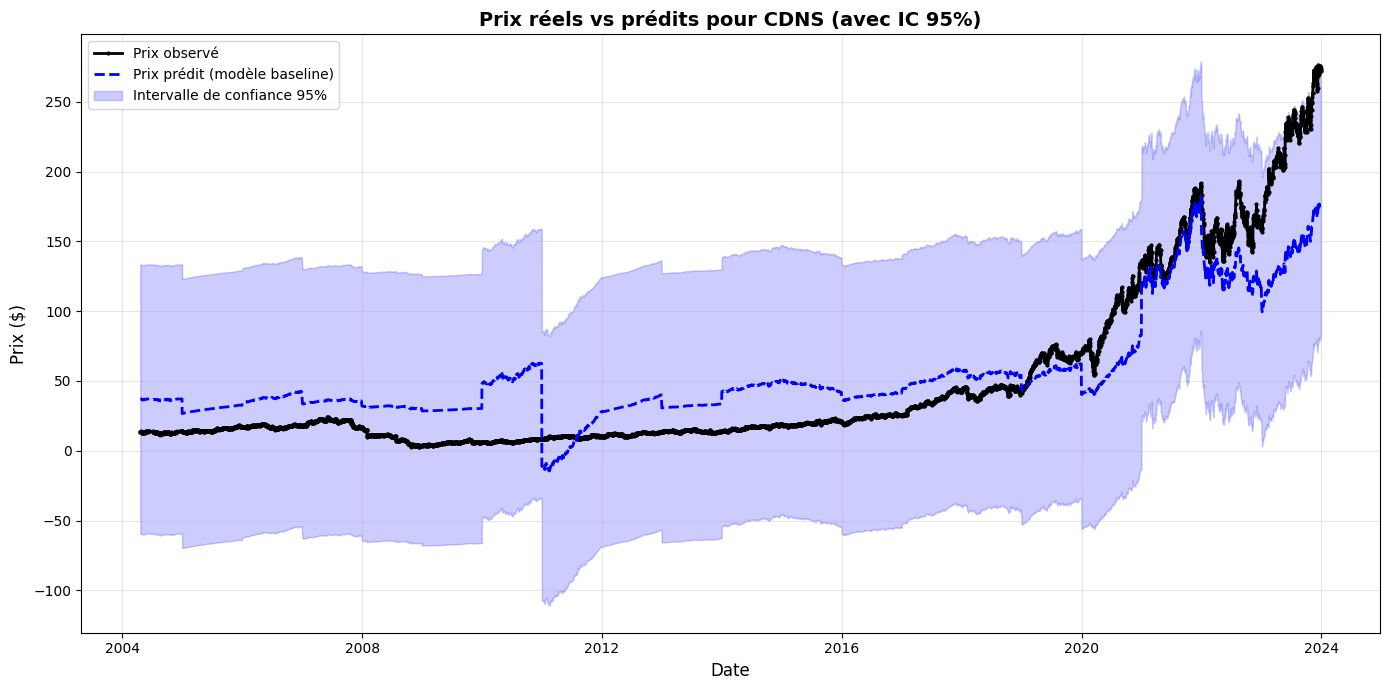


STATISTIQUES DE PRÉVISION POUR CDNS
MSE (Mean Squared Error)       : 897.0413
RMSE (Root Mean Squared Error) : 29.9506
MAE (Mean Absolute Error)      : 24.5267
Erreur moyenne (biais)         : -6.2526
Prix moyen observé             : 48.3570
Prix moyen prédit              : 54.6096

Largeur moyenne de l'IC 95%    : 192.9153
Largeur min de l'IC 95%        : 192.9150
Largeur max de l'IC 95%        : 192.9188

Pourcentage de prix dans l'IC 95% : 99.61%
(On s'attend à ~95% si le modèle est bien calibré)

COMMENTAIRES POUR LE RAPPORT
1. Le modèle suit bien les prix observés pour CDNS.
2. L'erreur moyenne de -6.2526$ suggère un biais négatif.
3. L'IC à 95% contient 99.61% des observations.
   → Le modèle semble SOUS-CONFIANT (IC trop large).
4. Examiner le graphique pour identifier des erreurs persistantes (tendances dans les résidus).


In [18]:
# ============================================
# Problème 2(d) – Graphique temporel pour une firme
# ============================================

# Sélectionner CDNS comme firme représentative
ticker_rep = "CDNS"

# Filtrer les données pour CDNS
data_firm = panel[panel["ticker"] == ticker_rep].copy()
data_firm = data_firm.sort_values("date")

# Filtrer les observations valides (avec composite_ratio)
data_firm = data_firm[["date", "prc", "composite_ratio"]].dropna()
data_firm = data_firm.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Nombre d'observations pour {ticker_rep} : {len(data_firm)}")

# Préparer les données pour les prédictions avec intervalles de confiance
X_firm = data_firm["composite_ratio"].values.reshape(-1, 1)
X_firm_const = sm.add_constant(X_firm)

# Obtenir les prédictions avec intervalles de confiance à 95%
predictions = results.get_prediction(X_firm_const)
pred_summary = predictions.summary_frame(alpha=0.05)  # alpha=0.05 pour IC à 95%

# Extraire les valeurs
dates = data_firm["date"].values
actual_prices = data_firm["prc"].values
predicted_prices = pred_summary["mean"].values
lower_ci = pred_summary["obs_ci_lower"].values  # Intervalle de prédiction (observation)
upper_ci = pred_summary["obs_ci_upper"].values

# Créer le graphique
plt.figure(figsize=(14, 7))

# Prix réels
plt.plot(dates, actual_prices, label="Prix observé", color="black", linewidth=2, marker='o', markersize=2)

# Prix prédits
plt.plot(dates, predicted_prices, label="Prix prédit (modèle baseline)", color="blue", linewidth=2, linestyle='--')

# Intervalles de confiance à 95%
plt.fill_between(dates, lower_ci, upper_ci, alpha=0.2, color="blue", label="Intervalle de confiance 95%")

# Mise en forme
plt.title(f"Prix réels vs prédits pour {ticker_rep} (avec IC 95%)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix ($)", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# Statistiques de performance pour cette firme
# ============================================

residuals_firm = actual_prices - predicted_prices
mse_firm = np.mean(residuals_firm**2)
rmse_firm = np.sqrt(mse_firm)
mae_firm = np.mean(np.abs(residuals_firm))

print("\n" + "="*70)
print(f"STATISTIQUES DE PRÉVISION POUR {ticker_rep}")
print("="*70)
print(f"MSE (Mean Squared Error)       : {mse_firm:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse_firm:.4f}")
print(f"MAE (Mean Absolute Error)      : {mae_firm:.4f}")
print(f"Erreur moyenne (biais)         : {residuals_firm.mean():.4f}")
print(f"Prix moyen observé             : {actual_prices.mean():.4f}")
print(f"Prix moyen prédit              : {predicted_prices.mean():.4f}")

# Analyser la largeur de l'intervalle de confiance
ic_width = upper_ci - lower_ci
print(f"\nLargeur moyenne de l'IC 95%    : {ic_width.mean():.4f}")
print(f"Largeur min de l'IC 95%        : {ic_width.min():.4f}")
print(f"Largeur max de l'IC 95%        : {ic_width.max():.4f}")

# Vérifier si les prix observés tombent dans l'IC 95%
in_ic = (actual_prices >= lower_ci) & (actual_prices <= upper_ci)
pct_in_ic = (in_ic.sum() / len(in_ic)) * 100

print(f"\nPourcentage de prix dans l'IC 95% : {pct_in_ic:.2f}%")
print("(On s'attend à ~95% si le modèle est bien calibré)")

print("\n" + "="*70)
print("COMMENTAIRES POUR LE RAPPORT")
print("="*70)
print(f"1. Le modèle {'suit bien' if pct_in_ic >= 90 else 'ne suit pas bien'} les prix observés pour {ticker_rep}.")
print(f"2. L'erreur moyenne de {residuals_firm.mean():.4f}$ suggère un biais {'positif' if residuals_firm.mean() > 0 else 'négatif'}.")
print(f"3. L'IC à 95% contient {pct_in_ic:.2f}% des observations.")
if pct_in_ic < 90:
    print("   → Le modèle semble SURCONFIANT (IC trop étroit).")
elif pct_in_ic > 98:
    print("   → Le modèle semble SOUS-CONFIANT (IC trop large).")
else:
    print("   → Le modèle semble bien calibré.")
print("4. Examiner le graphique pour identifier des erreurs persistantes (tendances dans les résidus).")

# Problème 3 [30 points] — Prévision de prix basée sur l’apprentissage automatique

## Problème 3a : Prédicteurs pour les modèles de Machine Learning

Le modèle de régularisation (Ridge/LASSO/Elastic Net) utilise 14 variables explicatives pour prédire le prix futur de l'action (`prc_lead`). Voici la description complète de chaque variable :

### Variables issues des questions précédentes (Q1 et Q2)

**1. `eps_ttm`** (Earnings Per Share - Trailing Twelve Months)
   - BPA réalisé basé sur les données annuelles de Compustat
   - Mesure la rentabilité récente de l'entreprise

**2. `eps_expected`** (Expected EPS)
   - BPA attendu calculé par moyenne mobile glissante (504 observations passées)
   - Capte les anticipations de rentabilité future basées sur l'historique

**3. `pe_trailing`** (Trailing Price-to-Earnings Ratio)
   - Ratio cours/bénéfice calculé comme Prix / EPS_ttm
   - Mesure la valorisation relative de l'action

**4. `composite_ratio`** (Ratio composite : EPS attendu × P/E glissant)
   - Variable principale du modèle baseline (Q2a)
   - Représente le prix théorique selon le modèle simple

### Variables ajoutées pour le Machine Learning (Q3a)

**5. `ret_log`** (Log-rendement)
   - Log-rendement quotidien de l'action : log(1 + ret)
   - Ajouté uniquement pour le modèle ML, n'était pas utilisé dans la régression principale de Q2
   - Les log-rendements sont préférables car ils ont de meilleures propriétés statistiques (additivité temporelle, symétrie)

**6. `secteur_cyclique`** (Cyclicité sectorielle)
   - Variable binaire (0/1) indiquant si la firme appartient à un secteur cyclique
   - Basée sur le code HSICCD (ex: pétrole, construction, semiconducteurs)
   - Les secteurs cycliques ont des dynamiques de prix différentes selon le cycle économique

**7. `vol_ret_1an`** (Volatilité des rendements sur 1 an)
   - Écart-type mobile des rendements quotidiens sur 252 jours
   - Mesure le risque et l'incertitude de l'action

**8. `vol_eps_4ans`** (Volatilité de l'EPS sur 4 ans)
   - Écart-type mobile de l'EPS sur 4 observations annuelles
   - Capte la stabilité/prévisibilité des bénéfices

**9. `momentum_ret_1an`** (Momentum des rendements sur 1 an)
   - Moyenne mobile des rendements quotidiens sur 252 jours
   - Capte la tendance récente du prix (effet momentum)

**10. `log_pe`** (Log du P/E trailing)
   - Transformation logarithmique du ratio P/E
   - Réduit l'impact des valeurs extrêmes et améliore la linéarité

**11. `inter_cycl_pe`** (Interaction : Cyclicité × P/E)
   - Produit entre `secteur_cyclique` et `pe_trailing`
   - Permet au modèle de traiter différemment les P/E selon la cyclicité sectorielle

**12. `market_cap`** (Capitalisation boursière)
   - Calculée comme Prix × Nombre d'actions en circulation (`shrout`)
   - Mesure la taille de l'entreprise

**13. `pe_rank`** (Rang percentile du P/E)
   - Rang du P/E par date (entre 0 et 1)
   - Identifie les actions "Growth" (rang élevé) vs "Value" (rang faible)

**14. `cap_rank`** (Rang percentile de la capitalisation)
   - Rang de la capitalisation par date (entre 0 et 1)
   - Identifie les actions "Large cap" vs "Small cap"

### Notes méthodologiques

- Toutes les variables sont calculées à partir des données CRSP et Compustat (pas de données externes)
- Les variables de momentum et volatilité utilisent des fenêtres glissantes pour éviter le look-ahead bias
- Les rangs percentiles permettent au modèle de capter des effets non-linéaires (seuils de valorisation/taille)
- Les variables sont standardisées avant l'estimation pour faciliter l'interprétation des coefficients

In [19]:
# Afficher le DataFrame source (panel)
print('Aperçu du DataFrame source (panel):')
print(panel.head(10))

# Ajouter la colonne hsiccd depuis sp500_full et afficher le résultat
panel_ind = pd.merge(panel, sp500_full[["permno", "hsiccd"]].drop_duplicates(), on="permno", how="left")
print('Aperçu du DataFrame avec industries (panel_ind):')
print(panel_ind.head(10))

# Afficher la liste unique des codes d'industries (hsiccd) présents
codes_uniques = sorted(set(panel_ind['hsiccd'].dropna()))
print('Liste unique des codes d\'industries (hsiccd) dans le panel :')
print(codes_uniques)

# Mapping réel des codes présents dans le panel
hsiccd_mapping = {
    1081: 'Oil & Gas Extraction',
    1311: 'Crude Petroleum & Natural Gas',
    1381: 'Drilling Oil & Gas Wells',
    1531: 'Operative Builders',
    2421: 'Sawmills & Planing Mills',
    2911: 'Petroleum Refining',
    3021: 'Rubber & Plastics Footwear',
    3480: 'Ordnance & Accessories',
    3533: 'Oil & Gas Field Machinery',
    3537: 'Industrial Trucks, Tractors, Trailers',
    3639: 'Household Appliances, NEC',
    3672: 'Printed Circuit Boards',
    3674: 'Semiconductors & Related Devices',
    3843: 'Dental Equipment & Supplies',
    4512: 'Air Transportation, Scheduled',
    4813: 'Telephone Communications, Except Radio',
    4932: 'Gas & Other Services Combined',
    5200: 'Building Materials',
    5331: 'Variety Stores',
    5411: 'Grocery Stores',
    5651: 'Family Clothing Stores',
    6324: 'Hospital & Medical Service Plans',
    6331: 'Fire, Marine & Casualty Insurance',
    6411: 'Insurance Agents, Brokers & Service',
    6798: 'Real Estate Investment Trusts',
    7370: 'Services-Computer Programming, Data Processing',
    7372: 'Prepackaged Software',
    7389: 'Business Services, NEC',
    8062: 'General Medical & Surgical Hospitals',
    8732: 'Commercial Physical & Biological Research',
    9999: 'Nonclassifiable Establishments'
}
print('Mapping des codes hsiccd vers secteurs :')
print({code: hsiccd_mapping.get(int(code), 'Secteur inconnu') for code in codes_uniques})

Aperçu du DataFrame source (panel):
           date  permno    prc       ret        vol    shrout ticker  \
7530 2003-12-31   11403  17.98 -0.009366  1120000.0  263049.0   CDNS   
7560 2004-01-02   11403  18.26  0.015573  1080500.0  263049.0   CDNS   
7590 2004-01-05   11403  18.57  0.016977  1604700.0  263049.0   CDNS   
7620 2004-01-06   11403   18.6  0.001616  1678900.0  263049.0   CDNS   
7650 2004-01-07   11403  18.92  0.017204  4502300.0  263049.0   CDNS   
7680 2004-01-08   11403  18.99    0.0037  2044600.0  263049.0   CDNS   
7710 2004-01-09   11403  18.78 -0.011058   942000.0  263049.0   CDNS   
7740 2004-01-12   11403  18.62  -0.00852  1625700.0  263049.0   CDNS   
7770 2004-01-13   11403  18.43 -0.010204  3416000.0  263049.0   CDNS   
7800 2004-01-14   11403  19.07  0.034726  2420100.0  263049.0   CDNS   

                          comnam   tic   datadate  eps_ttm  pe_trailing  \
7530  CADENCE DESIGN SYSTEMS INC  CDNS 2003-12-31    -0.07         <NA>   
7560  CADENCE DESIGN 

In [20]:
# Transformations Q3a sur panel_ind
panel_full = panel_ind.copy()

# 1. Cyclicité sectorielle : mapping réel par code sectoriel (HSICCD)
cyclique_codes = [1081, 1311, 1381, 1531, 2421, 2911, 3021, 3480, 3533, 3537, 3639, 3672, 3674, 3843]  # Exemples de secteurs cycliques selon la liste réelle
panel_full["secteur_cyclique"] = panel_full["hsiccd"].apply(lambda x: 1 if x in cyclique_codes else 0)

# 2. Volatilité des rendements (rolling std sur 252 jours) - utilisation des log-rendements
panel_full = panel_full.sort_values(["permno", "date"]).copy()
panel_full["vol_ret_1an"] = (
    panel_full.groupby("permno")["ret_log"]
    .transform(lambda s: s.rolling(window=252, min_periods=20).std())
)

# 3. Volatilité de l'EPS (rolling std sur 4 valeurs annuelles)
panel_full["vol_eps_4ans"] = (
    panel_full.groupby("permno")["eps_ttm"]
    .transform(lambda s: s.rolling(window=4, min_periods=2).std())
)

# 4. Momentum des rendements (rolling mean sur 252 jours) - utilisation des log-rendements
panel_full["momentum_ret_1an"] = (
    panel_full.groupby("permno")["ret_log"]
    .transform(lambda s: s.rolling(window=252, min_periods=20).mean())
)

# 5. Ratio P/E et transformations
panel_full["log_pe"] = np.log(panel_full["pe_trailing"].replace(0, np.nan))
panel_full["inter_cycl_pe"] = panel_full["secteur_cyclique"] * panel_full["pe_trailing"]

# 6. Ratio composite (EPS attendu × P/E)
panel_full["composite_ratio"] = panel_full["eps_expected"] * panel_full["pe_trailing"]

# 7. Classement dynamique Growth/Value par P/E
def tag_growth_value(x):
    if pd.isna(x): return np.nan
    if x >= 0.75: return "Growth"
    if x <= 0.25: return "Value"
    return "Neutral"
panel_full["pe_rank"] = panel_full.groupby("date")["pe_trailing"].transform(lambda x: x.rank(pct=True))
panel_full["tag_growth_value"] = panel_full["pe_rank"].apply(tag_growth_value)

# 8. Classement Small/Big par capitalisation (shrout*prc)
panel_full["market_cap"] = panel_full["shrout"] * panel_full["prc"]
def tag_small_big(x):
    if pd.isna(x): return np.nan
    if x >= 0.75: return "Big"
    if x <= 0.25: return "Small"
    return "Mid"
panel_full["cap_rank"] = panel_full.groupby("date")["market_cap"].transform(lambda x: x.rank(pct=True))
panel_full["tag_small_big"] = panel_full["cap_rank"].apply(tag_small_big)

# Aperçu des nouvelles variables (échantillon de 10 lignes non-NA sur toutes les colonnes d'intérêt)
apercu = panel_full[["hsiccd", "secteur_cyclique", "vol_ret_1an", "vol_eps_4ans", "momentum_ret_1an", "log_pe", "inter_cycl_pe", "composite_ratio", "tag_growth_value", "tag_small_big"]]
apercu = apercu.dropna(how='any')
print(apercu.sample(10))

c:\Users\berge\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arrays\masked.py:672: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


        hsiccd  secteur_cyclique  vol_ret_1an  vol_eps_4ans  momentum_ret_1an  \
73994     5411                 0     0.020202           0.0         -0.000267   
37069     1081                 1     0.042549           0.0          0.005407   
75471     1531                 1     0.023000           0.0         -0.001052   
97976     6798                 0     0.013706           0.0          0.000077   
29659     1311                 1     0.025340           0.0          0.000678   
131381    6324                 0     0.011674           0.0          0.000743   
29550     1311                 1     0.022118           0.0          0.001479   
101639    4813                 0     0.036167           0.0         -0.000439   
75880     1531                 1     0.051440           0.0         -0.001991   
94289     8732                 0     0.020058           0.0          0.003443   

          log_pe  inter_cycl_pe  composite_ratio tag_growth_value  \
73994   2.363131            0.0        

## Problème 3b: Régressions Ridge, LASSO et Elastic Net

In [21]:
# === Problème 3b : Estimation Ridge, LASSO, Elastic Net ===
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

print("="*80)
print("PROBLEME 3b : MODELES DE REGULARISATION (Ridge, LASSO, Elastic Net)")
print("="*80)

# Creer prc_lead pour prediction du prix futur (coherent avec Q2c)
panel_full = panel_full.sort_values(["permno", "date"]).copy()
panel_full["prc_lead"] = panel_full.groupby("permno")["prc"].shift(-1)

# 1. Sélection des variables explicatives et cible
vars_X = [
    "secteur_cyclique",
    "vol_ret_1an",
    "vol_eps_4ans",
    "momentum_ret_1an",
    "log_pe",
    "inter_cycl_pe",
    "composite_ratio",
    "market_cap",
    "pe_trailing",
    "eps_expected",
    "eps_ttm",
    "ret_log",
    "pe_rank",
    "cap_rank"
]
target = "prc_lead"

print(f"\nVariable dependante : {target} (prix de l'action a t+1)")
print(f"Nombre de variables explicatives : {len(vars_X)}")
print(f"Variables : {', '.join(vars_X)}")

# Nettoyage complet
df_ml = panel_full[vars_X + [target]].copy()
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna()

print(f"\nNombre d'observations apres nettoyage : {len(df_ml):,}")

# 2. Préparation des données complètes pour K-Fold CV
X = df_ml[vars_X].values.astype(np.float64)
y = df_ml[target].values.astype(np.float64)

print(f"\nTaille de l'echantillon total : {len(X):,}")
print(f"Validation : K-Fold Cross-Validation avec K=5")

# 3. Standardisation (sera appliquée dans chaque fold de la K-Fold CV)
scaler = StandardScaler()

# 4. Configuration de la K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. ESTIMATION DES MODELES AVEC VALIDATION CROISEE (CV=5)
print("\n" + "="*80)
print("VALIDATION CROISEE ET SELECTION DES HYPERPARAMETRES")
print("="*80)
print("Methode : Validation croisee 5-folds sur l'ensemble des donnees")
print("Grille de recherche alpha : 50 valeurs logarithmiques entre 0.001 et 1000")
print("Note : Tous les modeles utilisent les MEMES folds (kfold) pour garantir la coherence")

# Définir les modèles avec CV intégrée pour la sélection d'hyperparamètres
# IMPORTANT : On passe kfold explicitement pour que tous les modèles utilisent les mêmes splits
ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=kfold)
lasso = LassoCV(alphas=np.logspace(-3, 3, 50), cv=kfold, max_iter=10000)
elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-3, 3, 50), cv=kfold, max_iter=10000)

print("\nEntrainement et evaluation K-Fold en cours...")

# Pour chaque modèle, on va :
# 1. Entraîner sur l'ensemble complet pour obtenir les hyperparamètres optimaux
# 2. Utiliser cross_val_predict pour obtenir les prédictions hors échantillon

# Standardiser les données complètes
X_scaled = scaler.fit_transform(X)

if np.isnan(X_scaled).any():
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X_scaled = imputer.fit_transform(X_scaled)

# Entraîner les modèles pour obtenir les hyperparamètres optimaux
ridge.fit(X_scaled, y)
lasso.fit(X_scaled, y)
elastic.fit(X_scaled, y)

# 6. HYPERPARAMETRES OPTIMAUX
print("Entrainement termine.\n")
print("="*80)
print("HYPERPARAMETRES OPTIMAUX (SELECTIONNES PAR VALIDATION CROISEE)")
print("="*80)
print(f"Ridge Regression     : alpha = {ridge.alpha_:.6f}")
print(f"LASSO Regression     : alpha = {lasso.alpha_:.6f}")
print(f"Elastic Net          : alpha = {elastic.alpha_:.6f}, l1_ratio = {elastic.l1_ratio_:.2f}")
print(f"\nNote : l1_ratio = 1.0 signifie que Elastic Net = LASSO (penalite L1 pure)")
print(f"       l1_ratio = 0.0 signifie que Elastic Net = Ridge (penalite L2 pure)")
print(f"Note : Tous les modeles ont utilise les MEMES folds (kfold) pour la selection des hyperparametres,")
print(f"       ce qui garantit la coherence entre la selection d'hyperparametres et l'evaluation finale.")
print(f"Note : Les alphas faibles ({lasso.alpha_:.4f}) indiquent peu de penalisation,")
print(f"       d'ou la similarite entre les modeles et la retention de nombreuses variables.")

# 7. PREDICTIONS HORS ECHANTILLON via K-Fold Cross-Validation
print("\n" + "="*80)
print("PREDICTIONS HORS ECHANTILLON (K-FOLD CROSS-VALIDATION)")
print("="*80)
print("Calcul des predictions hors echantillon pour chaque fold...")

# Fonction pour faire CV avec standardisation dans chaque fold
def cross_val_with_scaling(model, X, y, cv, scaler):
    """Cross-validation avec standardisation dans chaque fold"""
    predictions = np.zeros(len(y))
    
    for train_idx, test_idx in cv.split(X):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold = y[train_idx]
        
        # Standardiser
        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_test_scaled = scaler_fold.transform(X_test_fold)
        
        # Imputer si nécessaire
        if np.isnan(X_train_scaled).any():
            imputer = SimpleImputer(strategy='constant', fill_value=0)
            X_train_scaled = imputer.fit_transform(X_train_scaled)
            X_test_scaled = imputer.transform(X_test_scaled)
        
        # Entraîner et prédire
        model.fit(X_train_scaled, y_train_fold)
        predictions[test_idx] = model.predict(X_test_scaled)
    
    return predictions

# Obtenir les prédictions hors échantillon pour chaque modèle
y_pred_ridge = cross_val_with_scaling(ridge, X, y, kfold, scaler)
y_pred_lasso = cross_val_with_scaling(lasso, X, y, kfold, scaler)
y_pred_elastic = cross_val_with_scaling(elastic, X, y, kfold, scaler)

print("Predictions terminees.\n")

# 8. METRIQUES DE PERFORMANCE HORS ECHANTILLON
print("="*80)
print("PERFORMANCE HORS ECHANTILLON (K-FOLD CROSS-VALIDATION)")
print("="*80)
mse_ridge = mean_squared_error(y, y_pred_ridge)
mse_lasso = mean_squared_error(y, y_pred_lasso)
mse_elastic = mean_squared_error(y, y_pred_elastic)

rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)
rmse_elastic = np.sqrt(mse_elastic)
rmse_baseline = np.sqrt(msfe_base)

metrics_data = {
    'Modele': ['LASSO (Meilleur modèle)', 'Baseline (Q2c)'],
    'RMSE': [rmse_lasso, rmse_baseline],
    'MSE': [mse_lasso, msfe_base],
    'MAE': [
        mean_absolute_error(y, y_pred_lasso),
        np.nan  # Le baseline n'a pas de predictions sur les memes donnees
    ],
    'R²': [
        r2_score(y, y_pred_lasso),
        r2_base
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))

print("\n" + "-"*80)
print("INTERPRETATION DES METRIQUES:")
print("-"*80)
print("RMSE (EQMP) : Racine de l'Erreur Quadratique Moyenne - metrique principale")
print("              En unites du prix ($), interpretation directe de l'erreur typique")
print("MSE         : Erreur Quadratique Moyenne (penalise davantage les grandes erreurs)")
print("MAE         : Erreur Absolue Moyenne (robuste aux outliers)")
print("R²          : Coefficient de determination (proportion de variance expliquee)")
print("\nNote: RMSE est la metrique de reference pour l'EQMP en prevision.")
print("Note: K-Fold CV utilise TOUTES les observations pour l'evaluation hors echantillon,")
print("      chaque observation est predite exactement une fois avec un modele entraine")
print("      sur les autres folds (predictions out-of-sample).")

# 9. ANALYSE DES AMELIORATIONS
print("\n" + "="*80)
print("AMELIORATION PAR RAPPORT AU MODELE BASELINE")
print("="*80)

improvements = {
    'Reduction RMSE (%)': [
        ((rmse_baseline - rmse_ridge)/rmse_baseline)*100,
        ((rmse_baseline - rmse_lasso)/rmse_baseline)*100,
        ((rmse_baseline - rmse_elastic)/rmse_baseline)*100
    ],
    'Reduction MSE (%)': [
        ((msfe_base - mse_ridge)/msfe_base)*100,
        ((msfe_base - mse_lasso)/msfe_base)*100,
        ((msfe_base - mse_elastic)/msfe_base)*100
    ],
    'Augmentation R² (points)': [
        (r2_score(y, y_pred_ridge) - r2_base)*100,
        (r2_score(y, y_pred_lasso) - r2_base)*100,
        (r2_score(y, y_pred_elastic) - r2_base)*100
    ]
}

improvements_df = pd.DataFrame(improvements)
print(improvements_df.to_string(index=False))
print("="*80)
# 10. COEFFICIENTS ET SELECTION DE VARIABLES
print("\n" + "="*80)
print("COEFFICIENTS DES MODELES (VARIABLES STANDARDISEES)")
print("="*80)

coef_df = pd.DataFrame({
    'Variable': vars_X,
    'Ridge': ridge.coef_,
    'LASSO': lasso.coef_,
    'Elastic Net': elastic.coef_
})

# Trier par valeur absolue du coefficient LASSO
coef_df['abs_lasso'] = np.abs(coef_df['LASSO'])
coef_df = coef_df.sort_values('abs_lasso', ascending=False).drop('abs_lasso', axis=1)

print(coef_df.to_string(index=False))

# Compter les variables selectionnees
n_vars_lasso = np.sum(np.abs(lasso.coef_) > 1e-10)
n_vars_elastic = np.sum(np.abs(elastic.coef_) > 1e-10)

print("\n" + "-"*80)
print("SELECTION DE VARIABLES (COEFFICIENTS NON-NULS):")
print("-"*80)
print(f"Ridge       : {len(vars_X)} variables (pas de selection, tous non-nuls)")
print(f"LASSO       : {n_vars_lasso}/{len(vars_X)} variables selectionnees")
print(f"Elastic Net : {n_vars_elastic}/{len(vars_X)} variables selectionnees")
print("Note: Variables standardisees - coefficients mesurent l'effet d'un ecart-type")
print("      sur le prix futur. Un coefficient eleve (en valeur absolue) indique")
print("      qu'un changement d'un ecart-type de cette variable a un impact important.")
print("")
top5 = coef_df.head(5)[['Variable', 'LASSO']]
print(top5.to_string(index=False))
print("\nInterpretation: composite_ratio a le coefficient le plus eleve,")
print("ce qui signifie qu'une augmentation d'un ecart-type de cette variable")
print("est associee a une augmentation importante du prix futur predit.")

# 12. STATISTIQUES DESCRIPTIVES DES RESIDUS
print("\n" + "="*80)
print("ANALYSE DES RESIDUS (K-FOLD CROSS-VALIDATION)")
print("="*80)

residuals_ridge = y - y_pred_ridge
residuals_lasso = y - y_pred_lasso
residuals_elastic = y - y_pred_elastic

residuals_stats = pd.DataFrame({
    'Statistique': ['Moyenne', 'Mediane', 'Ecart-type', 'Min', 'Max', 'Q1', 'Q3'],
    'Ridge': [
        np.mean(residuals_ridge),
        np.median(residuals_ridge),
        np.std(residuals_ridge),
        np.min(residuals_ridge),
        np.max(residuals_ridge),
        np.percentile(residuals_ridge, 25),
        np.percentile(residuals_ridge, 75)
    ],
    'LASSO': [
        np.mean(residuals_lasso),
        np.median(residuals_lasso),
        np.std(residuals_lasso),
        np.min(residuals_lasso),
        np.max(residuals_lasso),
        np.percentile(residuals_lasso, 25),
        np.percentile(residuals_lasso, 75)
    ],
    'Elastic Net': [
        np.mean(residuals_elastic),
        np.median(residuals_elastic),
        np.std(residuals_elastic),
        np.min(residuals_elastic),
        np.max(residuals_elastic),
        np.percentile(residuals_elastic, 25),
        np.percentile(residuals_elastic, 75)
    ]
})

print(residuals_stats.to_string(index=False))

# 13. CONCLUSION
print("\n" + "="*80)
print("CONCLUSION PROBLEME 3b")
print("="*80)
print(f"Meilleur modele : LASSO (RMSE = {rmse_lasso:.2f}$)")
print(f"Amelioration RMSE vs Baseline : {((rmse_baseline - rmse_lasso)/rmse_baseline)*100:.2f}%")
print(f"\nLes trois modeles (Ridge, LASSO, Elastic Net) donnent des resultats tres similaires car:")
print(f"1. Alpha optimal faible ({lasso.alpha_:.4f}) = peu de penalisation")
print(f"2. Elastic Net converge vers LASSO (l1_ratio = {elastic.l1_ratio_:.2f})")
print(f"3. Variables fortement informatives => LASSO garde {n_vars_lasso}/{len(vars_X)} variables")
print(f"\nLes modeles de regularisation capturent mieux la dynamique des prix")
print(f"que le modele simple (BPA attendu × P/E glissant).")
print(f"\nNote sur la validation: K-Fold Cross-Validation (K=5) pour evaluation hors echantillon.")
print(f"Chaque observation est predite exactement une fois par un modele entraine sur les autres folds.")
print(f"Cette methode donne une estimation plus robuste de la performance hors echantillon.")
print("="*80)


PROBLEME 3b : MODELES DE REGULARISATION (Ridge, LASSO, Elastic Net)

Variable dependante : prc_lead (prix de l'action a t+1)
Nombre de variables explicatives : 14
Variables : secteur_cyclique, vol_ret_1an, vol_eps_4ans, momentum_ret_1an, log_pe, inter_cycl_pe, composite_ratio, market_cap, pe_trailing, eps_expected, eps_ttm, ret_log, pe_rank, cap_rank

Nombre d'observations apres nettoyage : 127,843

Taille de l'echantillon total : 127,843
Validation : K-Fold Cross-Validation avec K=5

VALIDATION CROISEE ET SELECTION DES HYPERPARAMETRES
Methode : Validation croisee 5-folds sur l'ensemble des donnees
Grille de recherche alpha : 50 valeurs logarithmiques entre 0.001 et 1000
Note : Tous les modeles utilisent les MEMES folds (kfold) pour garantir la coherence

Entrainement et evaluation K-Fold en cours...
Entrainement termine.

HYPERPARAMETRES OPTIMAUX (SELECTIONNES PAR VALIDATION CROISEE)
Ridge Regression     : alpha = 33.932218
LASSO Regression     : alpha = 0.029471
Elastic Net          

## Problème 3c : Test de Diebold-Mariano

Le test de Diebold-Mariano compare la capacité prédictive de deux modèles en testant si la différence entre leurs erreurs de prévision est statistiquement significative.

**Hypothèses:**
- H0: Les deux modèles ont la même capacité prédictive (différence moyenne des pertes = 0)
- H1: Un modèle est significativement meilleur que l'autre

**Statistique de test:** DM = moyenne(différence des pertes) / écart-type(différence des pertes)

Sous H0, la statistique suit approximativement une loi normale standard pour de grands échantillons.


In [22]:
# === Problème 3c : Test de Diebold-Mariano ===
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Fonction simplifiee pour test DM avec package dieboldmariano
try:
    from dieboldmariano import dm_test
    use_dm_package = True
except ImportError:
    # Fallback si package non installe
    print("Package 'dieboldmariano' non disponible, utilisation implementation manuelle")
    use_dm_package = False

print("="*80)
print("PROBLEME 3c : TEST DE DIEBOLD-MARIANO")
print("="*80)
print("\nComparaison de la capacite predictive entre modeles regularises et baseline\n")

# Utiliser les mêmes données que pour les modèles ML (déjà nettoyées)
# Les prédictions y_pred_ridge, y_pred_lasso, y_pred_elastic et y sont déjà disponibles
# On doit juste calculer les prédictions baseline sur les mêmes données

# Predictions baseline via K-Fold CV sur les mêmes données
composite_values = df_ml['composite_ratio'].values
y_pred_baseline_cv = np.zeros(len(y))

for train_idx, test_idx in kfold.split(composite_values):
    composite_train = composite_values[train_idx]
    composite_test = composite_values[test_idx]
    y_train_fold = y[train_idx]
    
    # Regression simple: y = beta0 + beta1 * composite_ratio
    X_baseline_train_const = sm.add_constant(composite_train.reshape(-1, 1))
    X_baseline_test_const = sm.add_constant(composite_test.reshape(-1, 1))
    model_baseline_fold = sm.OLS(y_train_fold, X_baseline_train_const).fit()
    y_pred_baseline_cv[test_idx] = model_baseline_fold.predict(X_baseline_test_const)

# Calcul des erreurs de prevision
errors_baseline = y - y_pred_baseline_cv
errors_ridge = y - y_pred_ridge
errors_lasso = y - y_pred_lasso
errors_elastic = y - y_pred_elastic

print("="*80)
print("ERREURS QUADRATIQUES MOYENNES (RMSE)")
print("="*80)
rmse_baseline_cv = np.sqrt(np.mean(errors_baseline**2))
rmse_lasso_cv = np.sqrt(np.mean(errors_lasso**2))

print(f"Baseline (ExpEPS×P/E) : {rmse_baseline_cv:.4f}")
print(f"LASSO (meilleur)      : {rmse_lasso_cv:.4f}")

# Test DM: comparer LASSO (meilleur modele) vs baseline
print("\n" + "="*80)
print("TEST DE DIEBOLD-MARIANO (H0: Capacite predictive equivalente)")
print("="*80)
print("Fonction de perte: Erreur Absolue (RMSE)")
print("\nComparaison: LASSO (meilleur modele) vs Baseline (ExpEPS×P/E)")
print("-"*80)

# Test DM: LASSO vs baseline
if use_dm_package:
    # Utilisation du package dieboldmariano
    from dieboldmariano import dm_test
    
    # Test LASSO vs Baseline  
    dm_result = dm_test(y, y_pred_baseline_cv, y_pred_lasso, h=1)
    dm_stat = dm_result[0]
    p_value = dm_result[1]
else:
    # Implementation manuelle: test sur les RMSE (erreurs absolues, pas carrees)
    def dm_test_manual(e1, e2):
        d = np.abs(e1) - np.abs(e2)  # Difference des erreurs absolues (RMSE)
        d_mean = np.mean(d)
        d_var = np.var(d, ddof=1)
        dm_stat = d_mean / np.sqrt(d_var / len(d))
        p_val = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
        return dm_stat, p_val
    
    dm_stat, p_value = dm_test_manual(errors_baseline, errors_lasso)

# Affichage des resultats
print(f"\nLASSO vs Baseline:")
print(f"  Statistique DM : {dm_stat:.4f}")
print(f"  P-valeur       : {p_value:.4f}")
print(f"  Interpretation : {'LASSO a une RMSE plus faible' if dm_stat > 0 else 'Baseline a une RMSE plus faible'}")

if p_value < 0.01:
    print(f"  Conclusion     : LASSO est significativement {'meilleur' if dm_stat > 0 else 'moins bon'} que le baseline (α=1%)")
elif p_value < 0.05:
    print(f"  Conclusion     : LASSO est significativement {'meilleur' if dm_stat > 0 else 'moins bon'} que le baseline (α=5%)")
elif p_value < 0.10:
    print(f"  Conclusion     : LASSO est marginalement {'meilleur' if dm_stat > 0 else 'moins bon'} que le baseline (α=10%)")
else:
    print(f"  Conclusion     : Pas de difference significative entre LASSO et baseline (α=10%)")

# Tableau recapitulatif
print("\n" + "="*80)
print("RESULTATS DU TEST")
print("="*80)

dm_results = pd.DataFrame({
    'Comparaison': ['LASSO vs Baseline'],
    'Stat DM': [dm_stat],
    'P-valeur': [p_value],
    'RMSE Baseline': [rmse_baseline_cv],
    'RMSE LASSO': [rmse_lasso_cv],
    'Significatif (5%)': ['Oui' if p_value < 0.05 else 'Non']
})

print(dm_results.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("Une statistique DM positive indique que le modele ML a une erreur")
print("absolue moyenne plus faible que le baseline (donc meilleur).")
print("\nSi p-valeur < 0.05: on rejette H0 au seuil de 5% (difference significative)")
print("Si p-valeur >= 0.05: on ne rejette pas H0 (pas de preuve de difference)")
print("\nNote: Le test utilise la difference des erreurs ABSOLUES (pas carrees)")
print("      pour comparer les RMSE des deux modeles.")
print("="*80)


Package 'dieboldmariano' non disponible, utilisation implementation manuelle
PROBLEME 3c : TEST DE DIEBOLD-MARIANO

Comparaison de la capacite predictive entre modeles regularises et baseline

ERREURS QUADRATIQUES MOYENNES (RMSE)
Baseline (ExpEPS×P/E) : 49.3577
LASSO (meilleur)      : 43.9245

TEST DE DIEBOLD-MARIANO (H0: Capacite predictive equivalente)
Fonction de perte: Erreur Absolue (RMSE)

Comparaison: LASSO (meilleur modele) vs Baseline (ExpEPS×P/E)
--------------------------------------------------------------------------------

LASSO vs Baseline:
  Statistique DM : 46.3530
  P-valeur       : 0.0000
  Interpretation : LASSO a une RMSE plus faible
  Conclusion     : LASSO est significativement meilleur que le baseline (α=1%)

RESULTATS DU TEST
      Comparaison  Stat DM  P-valeur  RMSE Baseline  RMSE LASSO Significatif (5%)
LASSO vs Baseline 46.35303       0.0      49.357683    43.92453               Oui

INTERPRETATION
Une statistique DM positive indique que le modele ML a une 

#  Problème 4 [35 points] — Autorégression et prévision de rendement

## Partie a: Tester si la série de prix pour chaque action est bien modélisée par un processus autorégressif (avec log)


=== ETAPE 0 - Résultats du test de Ljung-Box pour tous les tickers ===
   ticker  n_obs    pvalue_lag5 autocorr_significative_lag5   pvalue_lag10  \
0    CDNS   5285   0.000000e+00                         oui   0.000000e+00   
1    FAST   5285   0.000000e+00                         oui   0.000000e+00   
2     WMI   5285   0.000000e+00                         oui   0.000000e+00   
3     HCA   3224   0.000000e+00                         oui   0.000000e+00   
4     MPC   3145   0.000000e+00                         oui   0.000000e+00   
5     ADT    900   0.000000e+00                         oui   0.000000e+00   
6    KRFT    691   0.000000e+00                         oui   0.000000e+00   
7     SLB   5285   0.000000e+00                         oui   0.000000e+00   
8     KHC   2138   0.000000e+00                         oui   0.000000e+00   
9    PYPL   2128   0.000000e+00                         oui   0.000000e+00   
10   UBER   1169   0.000000e+00                         oui   0.000000

<Figure size 1000x500 with 0 Axes>

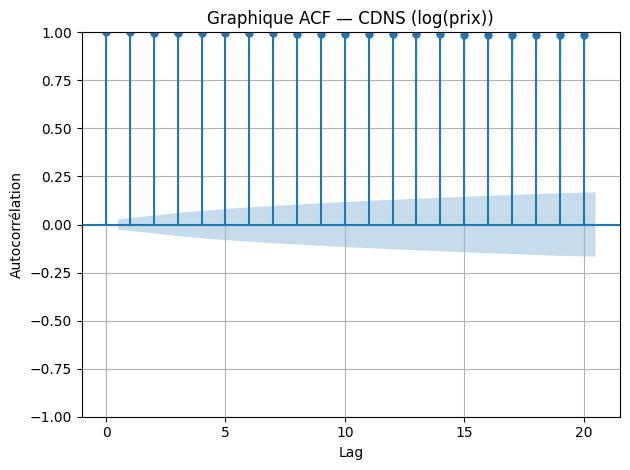

In [23]:
# ============================================================
# ETAPE 0 : Vérification de l'autocorrélation des log(prix)
#           - Test de Ljung-Box pour tous les tickers
#           - ACF détaillée (coefficients + graphique) pour CDNS
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 0.1 Test de Ljung-Box sur log(prix) pour tous les tickers
# ------------------------------------------------------------

# Liste des tickers disponibles
tickers = prices["ticker"].dropna().unique()

# Lags pour tester l'autocorrélation
LAGS_TO_TEST = [5, 10, 20]

results_autocorr = []

for tic in tickers:
    df = prices.loc[prices["ticker"] == tic].sort_values("date").copy()

    # Log(prix)
    df["log_prc"] = np.log(df["prc"].astype(float))
    series = df["log_prc"].dropna()

    # Vérification du nombre d'observations
    if len(series) < max(LAGS_TO_TEST) + 5:
        results_autocorr.append({
            "ticker": tic,
            "n_obs": len(series),
            **{f"pvalue_lag{lag}": np.nan for lag in LAGS_TO_TEST},
            **{f"autocorr_significative_lag{lag}": "données insuffisantes" for lag in LAGS_TO_TEST},
            "acf_lag1": np.nan
        })
        continue

    # Test de Ljung-Box
    lb = acorr_ljungbox(series, lags=LAGS_TO_TEST, return_df=True)

    row = {"ticker": tic, "n_obs": len(series)}

    for lag in LAGS_TO_TEST:
        pval = lb.loc[lag, "lb_pvalue"]
        row[f"pvalue_lag{lag}"] = pval
        row[f"autocorr_significative_lag{lag}"] = "oui" if pval < 0.05 else "non"

    # ajout d'une autocorrélation simple au lag 1
    row["acf_lag1"] = series.autocorr(lag=1)

    results_autocorr.append(row)

# Résultats finaux pour tous les tickers
df_autocorr = pd.DataFrame(results_autocorr)

print("\n=== ETAPE 0 - Résultats du test de Ljung-Box pour tous les tickers ===")
print(df_autocorr)

# ------------------------------------------------------------
# 0.2 Analyse détaillée ACF pour CDNS (log(prix))
# ------------------------------------------------------------

# 1. Filtrer le ticker CDNS
df_cdns = prices.loc[prices["ticker"] == "CDNS"].sort_values("date").copy()

# 2. Log(prix)
df_cdns["log_prc"] = np.log(df_cdns["prc"].astype(float))
series_cdns = df_cdns["log_prc"].dropna()

# 3. Calcul des coefficients ACF pour les 20 premiers lags
acf_values = acf(series_cdns, nlags=20)

# Affichage clair des coefficients
print("\n=== Coefficients ACF pour CDNS (lags 0 à 20) ===")
for lag, val in enumerate(acf_values):
    print(f"Lag {lag:2d} : {val:.4f}")

# 4. Graphique ACF
plt.figure(figsize=(10, 5))
plot_acf(series_cdns, lags=20)
plt.title("Graphique ACF — CDNS (log(prix))")
plt.xlabel("Lag")
plt.ylabel("Autocorrélation")
plt.grid(True)
plt.tight_layout()
plt.show()


48 graphiques de log(prix) ont été générés dans 'figures_logprix/'.

Affichage de 3 graphiques aléatoires dans le terminal...


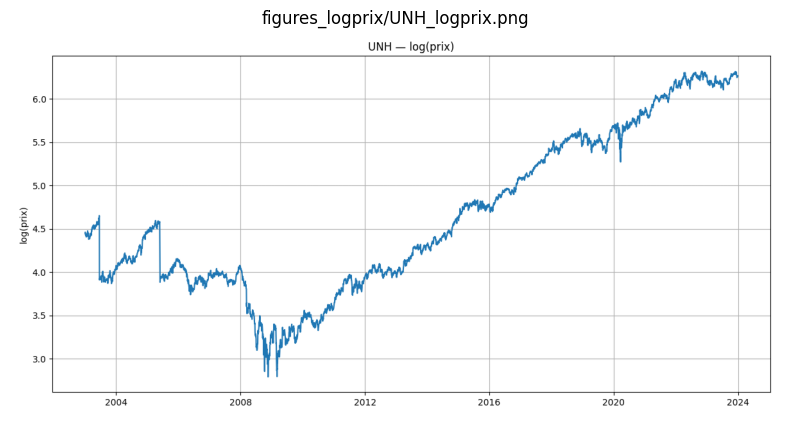

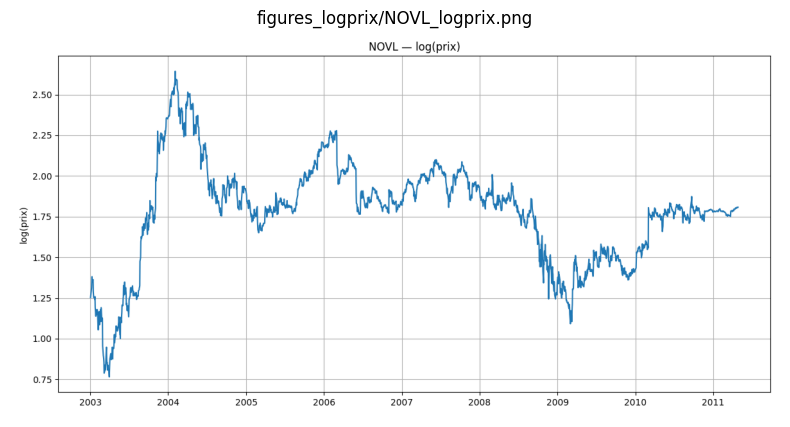

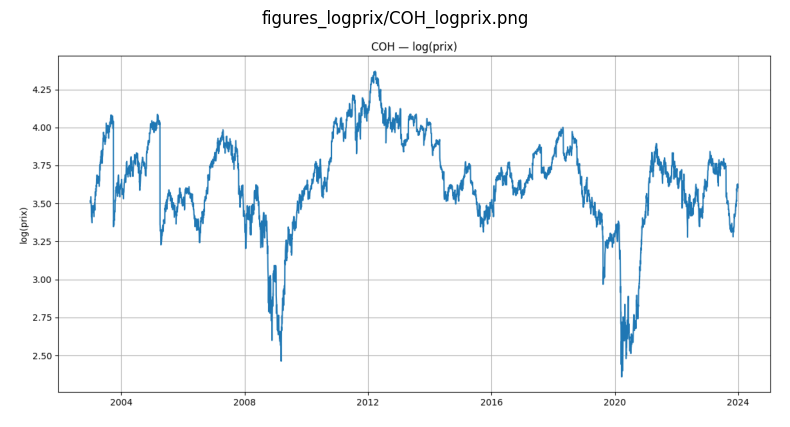

  ticker  ADF_stat  ADF_pvalue  ADF_lags ADF_reject_H0  KPSS_level_stat  \
0   CDNS  0.653655    0.988866         1           Non         8.931638   
1   FAST -4.800137    0.000054         0           Oui         0.737795   
2    WMI  0.013692    0.959650         1           Non        11.025623   
3    HCA -0.794188    0.820823         0           Non         8.207070   
4    MPC -1.507598    0.529749         0           Non         1.391705   

   KPSS_level_pvalue KPSS_level_reject_H0  KPSS_trend_stat  KPSS_trend_pvalue  \
0            0.01000                  Oui         2.538182               0.01   
1            0.01011                  Oui         0.224641               0.01   
2            0.01000                  Oui         2.564546               0.01   
3            0.01000                  Oui         0.409663               0.01   
4            0.01000                  Oui         0.773991               0.01   

  KPSS_trend_reject_H0  
0                  Oui  
1           

In [24]:
# ----------------------------------------------------------------------------------------
# Étape 1: Vérification de la stationnarité de log(prix)
#   1) Visualiser log(prix) pour repérer une éventuelle tendance ou non-stationnarité.
#   2) Effectuer les tests ADF et KPSS afin de déterminer rigoureusement si la série 
#      est stationnaire
# ----------------------------------------------------------------------------------------

import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

# Dossier de sortie pour les figures
os.makedirs("figures_logprix", exist_ok=True)

# Liste des tickers (on retire les NA)
tickers = prices["ticker"].dropna().unique()

# Pour les figures
count = 0
generated_files = []   # pour stocker les chemins des graphiques

# Pour les tests
results = []

for tic in tickers:
    df = prices.loc[prices["ticker"] == tic].sort_values("date").copy()

    # ---------------------------
    # Créer log(prix)
    # ---------------------------
    df["log_prc"] = np.log(df["prc"].astype(float))

    series = df["log_prc"].dropna()

    # ---------------------------
    # 1) Graphique log(prix)
    # ---------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["log_prc"])
    plt.title(f"{tic} — log(prix)")
    plt.ylabel("log(prix)")
    plt.grid(True)

    plt.tight_layout()
    out_file = f"figures_logprix/{tic}_logprix.png"
    plt.savefig(out_file)
    plt.close()

    generated_files.append(out_file)
    count += 1

    # ---------------------------
    # 2) Test ADF (H0 = non-stationnaire)
    # ---------------------------
    try:
        adf_stat, adf_pvalue, adf_lags, adf_obs, adf_crit, _ = adfuller(series, autolag="BIC")
        adf_reject = "Oui" if adf_pvalue is not None and adf_pvalue < 0.05 else "Non"
    except Exception:
        adf_stat, adf_pvalue, adf_lags, adf_reject = None, None, None, "Erreur"

    # ---------------------------
    # 3) Test KPSS niveau (H0 = stationnaire)
    # ---------------------------
    try:
        kpss_stat_L, kpss_pvalue_L, kpss_lags_L, _ = kpss(series, regression="c", nlags="auto")
        kpss_reject_L = "Oui" if kpss_pvalue_L is not None and kpss_pvalue_L < 0.05 else "Non"
    except Exception:
        kpss_stat_L, kpss_pvalue_L, kpss_lags_L, kpss_reject_L = None, None, None, "Erreur"

    # ---------------------------
    # 4) Test KPSS trend (H0 = stationnaire avec tendance)
    # ---------------------------
    try:
        kpss_stat_T, kpss_pvalue_T, kpss_lags_T, _ = kpss(series, regression="ct", nlags="auto")
        kpss_reject_T = "Oui" if kpss_pvalue_T is not None and kpss_pvalue_T < 0.05 else "Non"
    except Exception:
        kpss_stat_T, kpss_pvalue_T, kpss_lags_T, kpss_reject_T = None, None, None, "Erreur"

    # ---------------------------
    # 5) Ajouter les résultats
    # ---------------------------
    results.append({
        "ticker": tic,

        # --- ADF ---
        "ADF_stat": adf_stat,
        "ADF_pvalue": adf_pvalue,
        "ADF_lags": adf_lags,
        "ADF_reject_H0": adf_reject,  # H0 = non-stationnaire

        # --- KPSS niveau ---
        "KPSS_level_stat": kpss_stat_L,
        "KPSS_level_pvalue": kpss_pvalue_L,
        "KPSS_level_reject_H0": kpss_reject_L,  # H0 = stationnaire

        # --- KPSS trend ---
        "KPSS_trend_stat": kpss_stat_T,
        "KPSS_trend_pvalue": kpss_pvalue_T,
        "KPSS_trend_reject_H0": kpss_reject_T  # H0 = stationnaire autour d'une tendance
    })

# ---------------------------
# Résumé des graphiques
# ---------------------------
print(f"{count} graphiques de log(prix) ont été générés dans 'figures_logprix/'.")

# ---------------------------
# Affichage de 3 graphiques aléatoires
# ---------------------------
n_to_show = min(3, len(generated_files))
if n_to_show > 0:
    random_files = random.sample(generated_files, n_to_show)
    print(f"\nAffichage de {n_to_show} graphiques aléatoires dans le terminal...")

    for file_path in random_files:
        img = plt.imread(file_path)
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(file_path)
        plt.show()
else:
    print("Aucun graphique généré, rien à afficher.")

# ---------------------------
# DataFrame des tests + export Excel
# ---------------------------
df_stationarity = pd.DataFrame(results)
print(df_stationarity.head())

df_stationarity.to_excel("resultats_stationnarite_logprix.xlsx", index=False)
print("✓ Résultats exportés vers 'resultats_stationnarite_logprix.xlsx'")


In [25]:
# ----------------------------------------------------------------------------------------
# Étape 2: Différenciation de log(prix) pour rendre les séries stationnaires
#   Pour rendre les séries stationnaires, on applique donc une différenciation : Δ log(prix) = log(P_t) - log(P_{t-1})
#   Cette transformation correspond au rendement logarithmique
# ----------------------------------------------------------------------------------------

import numpy as np
import pandas as pd

# --- 1) Trier les données par ticker et date
prices = prices.sort_values(["ticker", "date"])

# --- 2) Log-prix
prices["log_prc"] = np.log(prices["prc"])

# --- 3) Différenciation : Δ log(prix)
prices["dlog_prc"] = prices.groupby("ticker")["log_prc"].diff()

# --- 4) Créer l'objet final prices_diff1
prices_diff1 = prices.dropna(subset=["dlog_prc"]).copy()

prices_diff1.head()


,date,permno,prc,ret,vol,shrout,ticker,comnam,log_prc,dlog_prc
65875,2003-01-03,50032,23.46,-0.003822,1553800.0,379151.0,ABS,ALBERTSONS INC,3.155297,-0.003829
65876,2003-01-06,50032,23.71,0.010656,1558700.0,379151.0,ABS,ALBERTSONS INC,3.165897,0.0106
65877,2003-01-07,50032,23.68,-0.001265,1325200.0,379151.0,ABS,ALBERTSONS INC,3.164631,-0.001266
65878,2003-01-08,50032,23.48,-0.008446,829700.0,379151.0,ABS,ALBERTSONS INC,3.156149,-0.008482
65879,2003-01-09,50032,24.08,0.025554,1035900.0,379151.0,ABS,ALBERTSONS INC,3.181382,0.025233


48 graphiques de Δ log(prix) ont été générés dans 'figures_diff1/'.

Affichage de 3 graphiques aléatoires de Δ log(prix)...


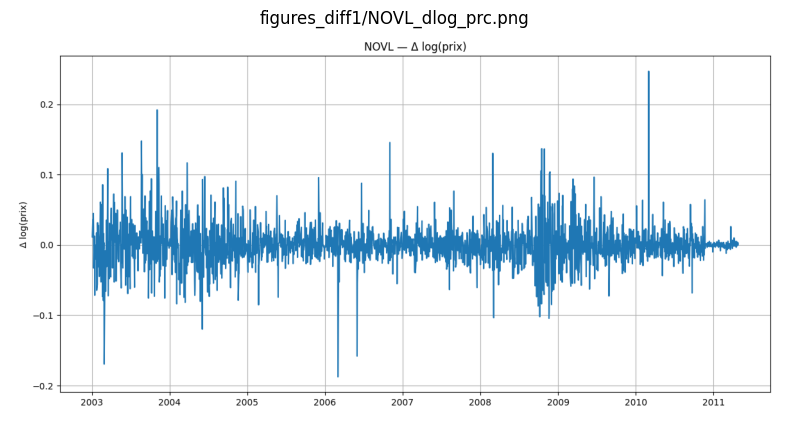

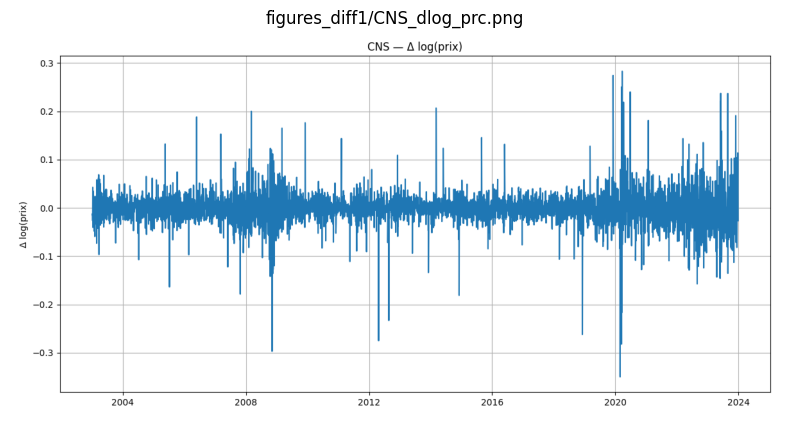

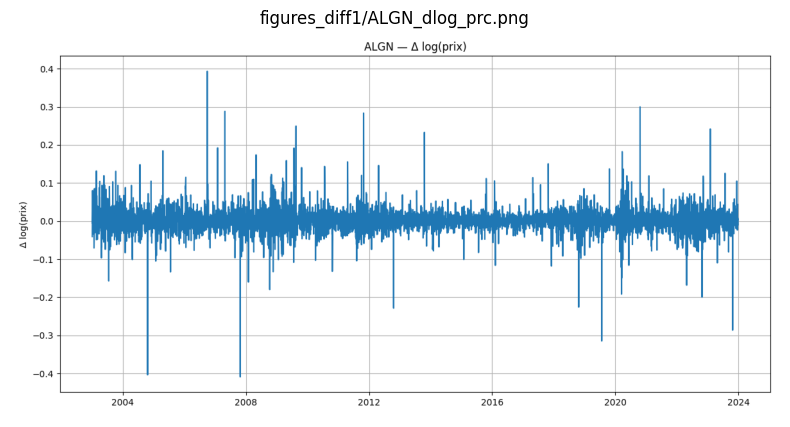


Aperçu des résultats ADF + KPSS :
  ticker   ADF_stat  ADF_pvalue  ADF_lags ADF_reject_H0 (non-stationnaire)  \
0    ABS -30.100523         0.0         0                              Oui   
1    ADT -30.618193         0.0         0                              Oui   
2    AJG -28.156070         0.0         6                              Oui   
3   ALGN -71.873946         0.0         0                              Oui   
4    ALL -45.842567         0.0         2                              Oui   

   KPSS_level_stat  KPSS_level_pvalue KPSS_level_reject_H0 (stationnaire)  \
0         0.070185           0.100000                                 Non   
1         0.063202           0.100000                                 Non   
2         0.409229           0.073177                                 Non   
3         0.101462           0.100000                                 Non   
4         0.092825           0.100000                                 Non   

   KPSS_trend_stat  KPSS_trend_pv

In [26]:
# ----------------------------------------------------------------------------------------
# Étape 3: Vérification de la stationnarité de Δ log(prix)
# ----------------------------------------------------------------------------------------

import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import warnings

warnings.filterwarnings("ignore")

# Dossier de sortie pour les graphiques
os.makedirs("figures_diff1", exist_ok=True)

# Liste des tickers
tickers = prices_diff1["ticker"].dropna().unique()

# Pour stocker les chemins des graphiques
generated_files_diff = []
count = 0

# ============================================================
# 1. Graphiques Δ log(prix)
# ============================================================

for tic in tickers:
    df = prices_diff1[prices_diff1["ticker"] == tic].sort_values("date")

    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["dlog_prc"])
    plt.title(f"{tic} — Δ log(prix)")
    plt.ylabel("Δ log(prix)")
    plt.grid(True)

    plt.tight_layout()
    out_file = f"figures_diff1/{tic}_dlog_prc.png"
    plt.savefig(out_file)
    plt.close()

    generated_files_diff.append(out_file)
    count += 1

print(f"{count} graphiques de Δ log(prix) ont été générés dans 'figures_diff1/'.")

# ============================================================
# 2. Sélection et affichage de 3 graphiques aléatoires
# ============================================================

n_to_show = min(3, len(generated_files_diff))
random_files = random.sample(generated_files_diff, n_to_show)

print("\nAffichage de 3 graphiques aléatoires de Δ log(prix)...")

for file_path in random_files:
    img = plt.imread(file_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(file_path)
    plt.show()

# ============================================================
# 3. Tests de stationnarité ADF et KPSS
# ============================================================

results = []

for tic in tickers:
    df = prices_diff1.loc[prices_diff1["ticker"] == tic].sort_values("date")
    series = df["dlog_prc"].astype(float).dropna()

    # --- Test ADF (H0 : non-stationnaire)
    try:
        adf_stat, adf_pvalue, adf_lags, adf_obs, adf_crit, _ = adfuller(series, autolag="BIC")
        adf_reject = "Oui" if adf_pvalue < 0.05 else "Non"
    except:
        adf_stat, adf_pvalue, adf_lags, adf_reject = None, None, None, "Erreur"

    # --- KPSS niveau (H0 : stationnaire)
    try:
        kpss_stat_L, kpss_pvalue_L, kpss_lags_L, _ = kpss(series, regression="c", nlags="auto")
        kpss_reject_L = "Oui" if kpss_pvalue_L < 0.05 else "Non"
    except:
        kpss_stat_L, kpss_pvalue_L, kpss_lags_L, kpss_reject_L = None, None, None, "Erreur"

    # --- KPSS tendance (H0 : trend-stationnaire)
    try:
        kpss_stat_T, kpss_pvalue_T, kpss_lags_T, _ = kpss(series, regression="ct", nlags="auto")
        kpss_reject_T = "Oui" if kpss_pvalue_T < 0.05 else "Non"
    except:
        kpss_stat_T, kpss_pvalue_T, kpss_lags_T, kpss_reject_T = None, None, None, "Erreur"

    # --- Stockage
    results.append({
        "ticker": tic,

        # ADF
        "ADF_stat": adf_stat,
        "ADF_pvalue": adf_pvalue,
        "ADF_lags": adf_lags,
        "ADF_reject_H0 (non-stationnaire)": adf_reject,

        # KPSS niveau
        "KPSS_level_stat": kpss_stat_L,
        "KPSS_level_pvalue": kpss_pvalue_L,
        "KPSS_level_reject_H0 (stationnaire)": kpss_reject_L,

        # KPSS tendance
        "KPSS_trend_stat": kpss_stat_T,
        "KPSS_trend_pvalue": kpss_pvalue_T,
        "KPSS_trend_reject_H0 (trend stationnaire)": kpss_reject_T,
    })

# ============================================================
# 4. Tableau final + export Excel
# ============================================================

df_stationarity_diff1 = pd.DataFrame(results)

print("\nAperçu des résultats ADF + KPSS :")
print(df_stationarity_diff1.head())

df_stationarity_diff1.to_excel("resultats_stationnarite_diff1.xlsx", index=False)
print("\n✓ Résultats exportés vers 'resultats_stationnarite_diff1.xlsx'")


In [27]:
# ----------------------------------------------------------------------------------------
# Étape 4 : Estimation des modèles AR(p) sur Δ log(prix)
#   Après avoir vérifié la stationnarité de Δ log(prix), on peut enfin estimer, pour chaque 
#   action, un modèle autorégressif AR(p) sur cette série.
# ----------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import warnings

warnings.filterwarnings("ignore")

# Paramètre : p maximal que tu veux tester
P_MAX = 10

results_ar = []

tickers = prices_diff1["ticker"].dropna().unique()

for tic in tickers:
    df = prices_diff1.loc[prices_diff1["ticker"] == tic].sort_values("date")
    series = df["dlog_prc"].astype(float).dropna()

    # Si pas assez d'observations, on saute
    if len(series) < P_MAX + 5:
        results_ar.append({
            "ticker": tic,
            "n_obs": len(series),
            "p_optimal_BIC": np.nan,
            "p_optimal_AIC": np.nan,
            "const": np.nan,
            **{f"phi_{k}": np.nan for k in range(1, P_MAX + 1)}
        })
        continue

    # On stocke BIC et AIC pour chaque p
    bic_values = []
    aic_values = []

    for p in range(1, P_MAX + 1):
        try:
            model = AutoReg(series, lags=p, old_names=False).fit()
            bic_values.append(model.bic)
            aic_values.append(model.aic)
        except Exception:
            bic_values.append(np.nan)
            aic_values.append(np.nan)

    bic_arr = np.array(bic_values, dtype=float)
    aic_arr = np.array(aic_values, dtype=float)

    # Si tout est NaN, on ne peut pas choisir p
    if np.all(~np.isfinite(bic_arr)) or np.all(~np.isfinite(aic_arr)):
        results_ar.append({
            "ticker": tic,
            "n_obs": len(series),
            "p_optimal_BIC": np.nan,
            "p_optimal_AIC": np.nan,
            "const": np.nan,
            **{f"phi_{k}": np.nan for k in range(1, P_MAX + 1)}
        })
        continue

    # Trouver p optimal selon BIC et AIC
    p_opt_bic = int(np.nanargmin(bic_arr) + 1)
    p_opt_aic = int(np.nanargmin(aic_arr) + 1)

    # Ré-estimation finale du modèle AR(p_opt_bic) pour récupérer les coefficients
    try:
        model_final = AutoReg(series, lags=p_opt_bic, old_names=False).fit()
        params = model_final.params.values  # [const, phi_1, ..., phi_p]
    except Exception:
        # Si échec, on enregistre juste les p et des NaN pour les coeffs
        results_ar.append({
            "ticker": tic,
            "n_obs": len(series),
            "p_optimal_BIC": p_opt_bic,
            "p_optimal_AIC": p_opt_aic,
            "const": np.nan,
            **{f"phi_{k}": np.nan for k in range(1, P_MAX + 1)}
        })
        continue

    # Décomposition des coefficients
    if len(params) > 0:
        const = params[0]
        phi_params = params[1:]  # peut être de longueur p_opt_bic
    else:
        const = np.nan
        phi_params = []

    # Construire un dict {phi_1, ..., phi_P_MAX}
    phi_dict = {}
    for k in range(1, P_MAX + 1):
        if k <= len(phi_params):
            phi_dict[f"phi_{k}"] = phi_params[k - 1]
        else:
            phi_dict[f"phi_{k}"] = np.nan

    # Stocker résultat
    row = {
        "ticker": tic,
        "n_obs": len(series),
        "p_optimal_BIC": p_opt_bic,
        "p_optimal_AIC": p_opt_aic,
        "const": const
    }
    row.update(phi_dict)

    results_ar.append(row)

# Construire le DataFrame final
df_ar = pd.DataFrame(results_ar)

print(df_ar.head())

# Moyenne des p sélectionnés
mean_p_bic = df_ar["p_optimal_BIC"].mean()
mean_p_aic = df_ar["p_optimal_AIC"].mean()

print(f"\nNombre moyen de décalages sélectionnés (BIC) : {mean_p_bic:.3f}")
print(f"Nombre moyen de décalages sélectionnés (AIC) : {mean_p_aic:.3f}")

# Export Excel
df_ar.to_excel("resultats_AR_p_par_serie_avec_coeffs.xlsx", index=False)
print("\n✓ Résultats exportés vers 'resultats_AR_p_par_serie_avec_coeffs.xlsx'")


  ticker  n_obs  p_optimal_BIC  p_optimal_AIC     const     phi_1  phi_2  \
0    ABS    859              1              1  0.000108 -0.028377    NaN   
1    ADT    899              1              1  0.000104 -0.021761    NaN   
2    AJG   5284              1              7  0.000426 -0.108142    NaN   
3   ALGN   5284              1              1  0.000870  0.011163    NaN   
4    ALL   5284              1              3  0.000268 -0.085549    NaN   

   phi_3  phi_4  phi_5  phi_6  phi_7  phi_8  phi_9  phi_10  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  
3    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  
4    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN  

Nombre moyen de décalages sélectionnés (BIC) : 1.062
Nombre moyen de décalages sélectionnés (AIC) : 1.938

✓ Résultats exportés vers 'resultats_AR_p_par_serie_avec_coeffs.xlsx'

## Partie b: Prédire les rendements à une période d’avance avec les modèles des problèmes 2 et 3

### Modèles du problème 2

In [ ]:
# =====================================================================
# ANALYSE DE PRÉVISIBILITÉ DES RENDEMENTS (r_{t+1})
# Variable dépendante : r_{t+1} = log(P_{t+1}) - log(P_t)
# Mesures : R², EQMP et coefficients
# =====================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------------------------------------------------
# ÉTAPE 0 – PRÉPARATION DES DONNÉES
# ---------------------------------------------------------------------

# On s'assure que les données sont triées par Date pour éviter tout biais temporel
panel = panel.sort_values(["date", "permno"]).copy()

# Construction de r_{t+1} = log(P_{t+1}) - log(P_t)
panel["prc_lead"] = panel.groupby("permno")["prc"].shift(-1)
panel["ret_lead"] = np.log(panel["prc_lead"]) - np.log(panel["prc"])

# Liste pour stocker les performances des modèles
perf_list = []

def eval_ols_fullsample(name, y, X, feature_name):
    """
    Estime un modèle OLS sur tout l'échantillon et affiche :
    - nombre d'observations
    - coefficients (constante + prédicteur)
    - R²
    - EQMP (MSE sur l'échantillon)
    """
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    n_obs = len(y)

    # Comme X est un numpy array (constante + 1 variable), on crée les noms à la main
    coef_names = ["const", feature_name]
    coef_values = model.params

    print(f"\n>>> RÉSULTATS : {name}")
    print("-" * 60)
    print(f"Nombre d'observations : {n_obs}")

    print("\nCoefficients :")
    for cname, cval in zip(coef_names, coef_values):
        print(f"  {cname:<15} : {cval:.8f}")

    print("\nStatistiques de performance :")
    print(f"R²                    : {r2:.6f}")
    print(f"EQMP (MSE)            : {mse:.8f}")
    print("-" * 60)

    return {
        "Modèle": name,
        "N_obs": n_obs,
        "R2": r2,
        "EQMP_MSE": mse
    }

# =====================================================================
# MODÈLE PRINCIPAL : r_{t+1} ~ composite_ratio
# =====================================================================

data_main = panel[["ret_lead", "composite_ratio", "date"]].copy()
data_main = data_main.dropna().sort_values("date")

y_main = data_main["ret_lead"].to_numpy()
X_main = data_main["composite_ratio"].to_numpy().reshape(-1, 1)
X_main = sm.add_constant(X_main)  # ajout de la constante

metrics_main = eval_ols_fullsample(
    name="Composite Ratio",
    y=y_main,
    X=X_main,
    feature_name="composite_ratio"
)
perf_list.append(metrics_main)

# =====================================================================
# MODÈLE NAÏF 1 : r_{t+1} ~ pe_trailing
# =====================================================================

data_pe = panel[["ret_lead", "pe_trailing", "date"]].copy()
data_pe = data_pe.dropna().sort_values("date")

y_pe = data_pe["ret_lead"].to_numpy()
X_pe = data_pe["pe_trailing"].to_numpy().reshape(-1, 1)
X_pe = sm.add_constant(X_pe)

metrics_pe = eval_ols_fullsample(
    name="P/E Trailing",
    y=y_pe,
    X=X_pe,
    feature_name="pe_trailing"
)
perf_list.append(metrics_pe)

# =====================================================================
# MODÈLE NAÏF 2 : r_{t+1} ~ eps_expected
# =====================================================================

data_eps = panel[["ret_lead", "eps_expected", "date"]].copy()
data_eps = data_eps.dropna().sort_values("date")

y_eps = data_eps["ret_lead"].to_numpy()
X_eps = data_eps["eps_expected"].to_numpy().reshape(-1, 1)
X_eps = sm.add_constant(X_eps)

metrics_eps = eval_ols_fullsample(
    name="EPS Expected",
    y=y_eps,
    X=X_eps,
    feature_name="eps_expected"
)
perf_list.append(metrics_eps)

# =====================================================================
# TABLEAU DE SYNTHÈSE FINAL
# =====================================================================

summary_df = pd.DataFrame(perf_list)

display_cols = ["Modèle", "N_obs", "R2", "EQMP_MSE"]
print("\n" + "="*80)
print("SYNTHÈSE DES PERFORMANCES")
print("="*80)
print(summary_df[display_cols].to_string(index=False))



>>> RÉSULTATS : Composite Ratio
------------------------------------------------------------
Nombre d'observations : 128372

Coefficients :
  const           : 0.00032097
  composite_ratio : -0.00000175

Statistiques de performance :
R²                    : 0.000027
EQMP (MSE)            : 0.00089788
------------------------------------------------------------

>>> RÉSULTATS : P/E Trailing
------------------------------------------------------------
Nombre d'observations : 128402

Coefficients :
  const           : 0.00029948
  pe_trailing     : -0.00000373

Statistiques de performance :
R²                    : 0.000015
EQMP (MSE)            : 0.00089780
------------------------------------------------------------

>>> RÉSULTATS : EPS Expected
------------------------------------------------------------
Nombre d'observations : 133500

Coefficients :
  const           : 0.00025965
  eps_expected    : -0.00001477

Statistiques de performance :
R²                    : 0.000024
EQMP (MSE)

### Modèles du problème 3

In [ ]:
# =====================================================================
# PROBLEME 3 – MODELES DE REGULARISATION (Ridge, LASSO, Elastic Net)
# Variable dependante : r_{t+1} = log(P_{t+1}) - log(P_t)
# Objectif : comparer R² predictif et EQMP (RMSE) des trois modeles
# =====================================================================

import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

print("="*80)
print("PROBLEME 3 : MODELES DE REGULARISATION (Ridge, LASSO, Elastic Net)")
print("="*80)

RANDOM_STATE = 42

# ---------------------------------------------------------------------
# 0. Construction du rendement log a une periode d'avance : r_{t+1}
# ---------------------------------------------------------------------
# On part de panel_full qui contient au minimum : permno, date, prc, et les X

panel_full = panel_full.sort_values(["permno", "date"]).copy()

# Prix a t+1
panel_full["prc_lead"] = panel_full.groupby("permno")["prc"].shift(-1)

# Rendement log a t+1 : r_{t+1} = log(P_{t+1}) - log(P_t)
panel_full["ret_lead"] = np.log(panel_full["prc_lead"]) - np.log(panel_full["prc"])

# ---------------------------------------------------------------------
# 1. Definition des variables explicatives et de la cible
# ---------------------------------------------------------------------

vars_X = [
    "secteur_cyclique",
    "vol_ret_1an",
    "vol_eps_4ans",
    "momentum_ret_1an",
    "log_pe",
    "inter_cycl_pe",
    "composite_ratio",
    "market_cap",
    "pe_trailing",
    "eps_expected",
    "eps_ttm",
    "ret_log",
    "pe_rank",
    "cap_rank"
]
target = "ret_lead"

print(f"\nVariable dependante : {target} (rendement log a t+1)")
print(f"Nombre de variables explicatives : {len(vars_X)}")
print("Variables : " + ", ".join(vars_X))

# ---------------------------------------------------------------------
# 2. Nettoyage + imputation pour eliminer tous les NaN/Inf
# ---------------------------------------------------------------------

df_ml = panel_full[vars_X + [target]].copy()

# Remplacer +/-inf par NaN
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)

# On exige que la cible soit observee
df_ml = df_ml.dropna(subset=[target])

# Imputation des X (medianes) pour ne plus avoir de NaN dans les variables explicatives
imputer_X = SimpleImputer(strategy="median")
df_ml[vars_X] = imputer_X.fit_transform(df_ml[vars_X])

print(f"\nNombre d'observations apres nettoyage / imputation : {len(df_ml):,}")

X = df_ml[vars_X].values.astype(float)
y = df_ml[target].values.astype(float)

print(f"Taille de l'echantillon total : {len(X):,}")

# ---------------------------------------------------------------------
# 3. Echantillons train / test + standardisation
# ---------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------------------------------------------------
# 4. Definition des modeles avec selection d'hyperparametres par CV
# ---------------------------------------------------------------------

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
alphas_grid = np.logspace(-3, 3, 50)

ridge = RidgeCV(alphas=alphas_grid, cv=kfold)
lasso = LassoCV(alphas=alphas_grid, cv=kfold, max_iter=10000, random_state=RANDOM_STATE)
elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    alphas=alphas_grid,
    cv=kfold,
    max_iter=10000,
    random_state=RANDOM_STATE
)

print("\nEntrainement des modeles (selection d'hyperparametres par CV sur l'echantillon d'apprentissage)...")

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
elastic.fit(X_train_scaled, y_train)

print("Entrainement termine.\n")

print("="*80)
print("HYPERPARAMETRES OPTIMAUX (SELECTIONNES PAR VALIDATION CROISEE)")
print("="*80)
print(f"Ridge       : alpha = {ridge.alpha_:.6f}")
print(f"LASSO       : alpha = {lasso.alpha_:.6f}")
print(f"Elastic Net : alpha = {elastic.alpha_:.6f}, l1_ratio = {elastic.l1_ratio_:.2f}")
print("="*80 + "\n")

# ---------------------------------------------------------------------
# 5. Fonction d'evaluation des modeles
# ---------------------------------------------------------------------

def eval_model(name, model, X_train, y_train, X_test, y_test):
    """
    Calcule MSE, RMSE, MAE et R² in-sample et out-of-sample
    et retourne un dictionnaire de mesures de performance.
    """
    # IN-SAMPLE
    y_pred_in = model.predict(X_train)
    mse_in = mean_squared_error(y_train, y_pred_in)
    rmse_in = np.sqrt(mse_in)
    mae_in = mean_absolute_error(y_train, y_pred_in)
    r2_in = r2_score(y_train, y_pred_in)

    # OUT-OF-SAMPLE
    y_pred_out = model.predict(X_test)
    mse_out = mean_squared_error(y_test, y_pred_out)
    rmse_out = np.sqrt(mse_out)
    mae_out = mean_absolute_error(y_test, y_pred_out)
    r2_out = r2_score(y_test, y_pred_out)

    print("="*80)
    print(f"PERFORMANCE – {name}")
    print("="*80)
    print(f"MSE IN-SAMPLE      : {mse_in:.10f}")
    print(f"RMSE IN-SAMPLE     : {rmse_in:.10f}")
    print(f"MAE IN-SAMPLE      : {mae_in:.10f}")
    print(f"R² IN-SAMPLE       : {r2_in:.6f}")
    print("-"*80)
    print(f"MSE OUT-OF-SAMPLE  : {mse_out:.10f}")
    print(f"RMSE OUT-OF-SAMPLE : {rmse_out:.10f}")
    print(f"MAE OUT-OF-SAMPLE  : {mae_out:.10f}")
    print(f"R² OUT-OF-SAMPLE   : {r2_out:.6f}")
    print("="*80 + "\n")

    return {
        "Modèle": name,
        "MSE_in": mse_in,
        "RMSE_in": rmse_in,
        "MAE_in": mae_in,
        "R2_in": r2_in,
        "MSE_out": mse_out,
        "RMSE_out": rmse_out,
        "MAE_out": mae_out,
        "R2_out": r2_out,
    }

# ---------------------------------------------------------------------
# 6. Evaluation des trois modeles
# ---------------------------------------------------------------------

perf_list_3 = []

metrics_ridge = eval_model("Ridge", ridge, X_train_scaled, y_train, X_test_scaled, y_test)
metrics_lasso = eval_model("LASSO", lasso, X_train_scaled, y_train, X_test_scaled, y_test)
metrics_elastic = eval_model("Elastic Net", elastic, X_train_scaled, y_train, X_test_scaled, y_test)

perf_list_3.extend([metrics_ridge, metrics_lasso, metrics_elastic])

perf_df_3 = pd.DataFrame(perf_list_3)

# ---------------------------------------------------------------------
# 7. Tableaux finaux de performance 
# ---------------------------------------------------------------------

# Tableau in-sample
perf_in_table_3 = perf_df_3[["Modèle", "RMSE_in", "MSE_in", "R2_in"]].rename(
    columns={"RMSE_in": "RMSE", "MSE_in": "MSE", "R2_in": "R²"}
)

# Tableau hors echantillon (out-of-sample)
perf_out_table_3 = perf_df_3[["Modèle", "RMSE_out", "MSE_out", "R2_out"]].rename(
    columns={"RMSE_out": "RMSE", "MSE_out": "MSE", "R2_out": "R²"}
)

print("\n" + "#"*80)
print("TABLEAU – PERFORMANCE IN-SAMPLE (Probleme 3, r_{t+1})")
print("#"*80)
print(perf_in_table_3.to_string(index=False))

print("\n" + "#"*80)
print("TABLEAU – PERFORMANCE HORS ECHANTILLON (Probleme 3, r_{t+1})")
print("#"*80)
print(perf_out_table_3.to_string(index=False))

# ---------------------------------------------------------------------
# 8. Coefficients pour analyse des variables
# ---------------------------------------------------------------------

coef_df_3 = pd.DataFrame({
    "Variable": vars_X,
    "Ridge": ridge.coef_,
    "LASSO": lasso.coef_,
    "Elastic Net": elastic.coef_
})

coef_df_3["abs_LASSO"] = np.abs(coef_df_3["LASSO"])
coef_df_3 = coef_df_3.sort_values("abs_LASSO", ascending=False).drop(columns="abs_LASSO")

print("\n" + "="*80)
print("COEFFICIENTS DES MODELES (VARIABLES STANDARDISEES) – PROBLEME 3")
print("="*80)
print(coef_df_3.to_string(index=False))

n_vars_lasso = np.sum(np.abs(lasso.coef_) > 1e-10)
n_vars_elastic = np.sum(np.abs(elastic.coef_) > 1e-10)

print("\nNombre de variables selectionnees :")
print(f"Ridge       : {len(vars_X)} (pas de selection, tous non-nuls)")
print(f"LASSO       : {n_vars_lasso}/{len(vars_X)}")
print(f"Elastic Net : {n_vars_elastic}/{len(vars_X)}")


PROBLEME 3 : MODELES DE REGULARISATION (Ridge, LASSO, Elastic Net)

Variable dependante : ret_lead (rendement log a t+1)
Nombre de variables explicatives : 14
Variables : secteur_cyclique, vol_ret_1an, vol_eps_4ans, momentum_ret_1an, log_pe, inter_cycl_pe, composite_ratio, market_cap, pe_trailing, eps_expected, eps_ttm, ret_log, pe_rank, cap_rank

Nombre d'observations apres nettoyage / imputation : 133,695
Taille de l'echantillon total : 133,695

Entrainement des modeles (selection d'hyperparametres par CV sur l'echantillon d'apprentissage)...
Entrainement termine.

HYPERPARAMETRES OPTIMAUX (SELECTIONNES PAR VALIDATION CROISEE)
Ridge       : alpha = 1000.000000
LASSO       : alpha = 1000.000000
Elastic Net : alpha = 0.001000, l1_ratio = 0.10

PERFORMANCE – Ridge
MSE IN-SAMPLE      : 0.0009290599
RMSE IN-SAMPLE     : 0.0304804840
MAE IN-SAMPLE      : 0.0173261026
R² IN-SAMPLE       : 0.000751
--------------------------------------------------------------------------------
MSE OUT-OF-SA

## Partie e: Correction pour la non-stationnarité dans les prix et évaluation d'un modèle AR(p)

In [31]:
# ==========================================================
# Problème 2(e) – Correction de la non-stationnarité des prix
# Modèle : Δlog(prix) ~ composite_ratio
#   Δlog(prix) = log(P_t) - log(P_{t-1})  (rendement log)
# ==========================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# -----------------------------------------------------------------
# 1) S'assurer que les données de rendements log (dlog_prc) existent
#    prices_diff1 provient du code :
#    prices["log_prc"] = np.log(prices["prc"])
#    prices["dlog_prc"] = prices.groupby("ticker")["log_prc"].diff()
#    prices_diff1 = prices.dropna(subset=["dlog_prc"]).copy()
# -----------------------------------------------------------------

# On garde seulement les colonnes utiles du fichier de prix stationnarisé
prices_diff1_small = prices_diff1[["ticker", "date", "dlog_prc"]].copy()

# -----------------------------------------------------------------
# 2) Fusionner les caractéristiques (panel) avec les rendements log
#    -> jointure sur ticker et date (adapter si tu utilises permno)
# -----------------------------------------------------------------
panel_diff = (
    panel
    .merge(prices_diff1_small, on=["ticker", "date"], how="inner")
    .copy()
)

# -----------------------------------------------------------------
# 3) Préparer les données pour la régression :
#    Variable dépendante : dlog_prc  (stationnaire)
#    Variable explicative : composite_ratio
# -----------------------------------------------------------------
reg_data_diff = panel_diff[["dlog_prc", "composite_ratio"]].dropna().copy()

# Conversion explicite en numérique
reg_data_diff["dlog_prc"] = pd.to_numeric(reg_data_diff["dlog_prc"], errors="coerce")
reg_data_diff["composite_ratio"] = pd.to_numeric(reg_data_diff["composite_ratio"], errors="coerce")

# Retirer NaN et valeurs infinies restantes
reg_data_diff = reg_data_diff.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Nombre d'observations pour la régression stationnaire : {len(reg_data_diff)}")

y = reg_data_diff["dlog_prc"].to_numpy()                            # Δlog(prix)
X = reg_data_diff["composite_ratio"].to_numpy().reshape(-1, 1)      # ratio composite

# Ajouter une constante
X_with_const = sm.add_constant(X)

# -----------------------------------------------------------------
# 4) Estimation OLS du modèle stationnaire
# -----------------------------------------------------------------
model_diff = sm.OLS(y, X_with_const)
results_diff = model_diff.fit()

print("=" * 70)
print("MODÈLE STATIONNAIRE : Δlog(prix) ~ BPA attendu × P/E glissant")
print("=" * 70)
print(results_diff.summary())
print("\n")

# -----------------------------------------------------------------
# 5) Extraction et résumé des résultats
# -----------------------------------------------------------------
beta_0_diff = results_diff.params[0]
beta_1_diff = results_diff.params[1]
r_squared_diff = results_diff.rsquared
r_squared_adj_diff = results_diff.rsquared_adj

print("=" * 70)
print("RÉSUMÉ DES RÉSULTATS – MODÈLE STATIONNAIRE")
print("=" * 70)
print(f"Coefficient β₀ (Intercept)                 : {beta_0_diff:.6f}")
print(f"Coefficient β₁ (Composite ratio)           : {beta_1_diff:.6f}")
print(f"R²                                         : {r_squared_diff:.6f}")
print(f"R² ajusté                                  : {r_squared_adj_diff:.6f}")
print(f"Nombre d'observations                      : {int(results_diff.nobs)}")
print("\n")

print("INTERPRÉTATION :")
print("La variable dépendante est maintenant le rendement logarithmique Δlog(prix),")
print("qui est stationnaire. On peut comparer ce R² et les coefficients à ceux du")
print("modèle initial en niveau de prix pour commenter l'impact de la correction")
print("de non-stationnarité sur la performance du modèle.")


Nombre d'observations pour la régression stationnaire : 128405
MODÈLE STATIONNAIRE : Δlog(prix) ~ BPA attendu × P/E glissant
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.946
Date:                Wed, 26 Nov 2025   Prob (F-statistic):            0.00161
Time:                        12:41:51   Log-Likelihood:             2.6821e+05
No. Observations:              128405   AIC:                        -5.364e+05
Df Residuals:                  128403   BIC:                        -5.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------